In [1]:
import datetime as dt
import gc
import os
import pickle as pkl
import time as timer
from functools import partial

import cartopy as ctp
import cupy as cp
from cdo import Cdo
from nco import Nco
import IPython.display as disp
import kolmogorov_smirnov as ks
import mannwhitneyu as mwu
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from matplotlib.offsetbox import AnchoredText
from joblib import Parallel, delayed
import numpy as np
import numpy.random as ran
import pandas as pd
import scipy.stats as sstats
import seaborn as sns
import xarray as xr
from ipywidgets import HTML, IntProgress, Text
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scripts.util import *

/apps/daint/UES/jenkins/7.0.UP03/21.09/daint-gpu/software/jupyterlab/3.2.8-CrayGNU-21.09-batchspawner-cuda/lib/python3.9/site-packages/cupy/_environment.py:434: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda110

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [2]:
def get_array(z):  # if we use cupy
    try:
        return z.get()
    except AttributeError:
        return z

SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
mpl.rcParams["animation.html"] = "jshtml"

CMAP = LinearSegmentedColormap.from_list(
    'gr', [
        [21 / 256, 176 / 256, 26 / 256, 1],
        [1, 1, 1, 1], 
        [229 / 256, 0, 0, 1], 
    ], N=50)

HERE = "__xarray_dataarray_variable__"

COLORS = [     # https://coolors.co/palette/ef476f-ffd166-06d6a0-118ab2-073b4c
    "#ef476f", # pinky red
    "#ffd166", # yellow
    "#06d6a0", # cyany green
    "#118ab2", # light blue
    "#073b4c", # dark blue
]
os.environ["CDO"] = "/project/pr133/hbanderi/miniconda3/envs/env/bin/cdo"
os.environ["NCOpath"] = "/apps/daint/UES/jenkins/7.0.UP03/21.09/daint-gpu/software/NCO/5.0.4-CrayGNU-21.09/bin"
os.environ["PATH"] += ":/apps/daint/UES/jenkins/7.0.UP03/21.09/daint-gpu/software/NCO/5.0.4-CrayGNU-21.09/bin"
PATHBASE = "/scratch/snx3000/hbanderi/data"

## Initialize all parameters, store in metadata file

In [3]:
n_sel = 100  # how many times we randomly select runs, make it n_sel % n_engine = 0
alpha = 0.05  # significance level
n_mem = 100  # members per ensemble

freq = "1D"  # supersampling frequency
n_sam = {f"{i}D": i * 75 for i in range(1, 8)}
n_sam["1w"] = 1000  
n_sam["2w"] = 2000  
n_sam["1M"] = 3000  
n_sam["3M"] = 5000  
n_sam["1MS"] = 3000 
n_sam["3MS"] = 5000  

u_crit = int(sstats.norm.ppf(
    q=1 - alpha, 
    loc=n_sam[freq] ** 2 / 2,
    scale=np.sqrt((n_sam[freq] ** 2 * (2 * n_sam[freq] + 1)) / 12)
))
ndf = 2 * n_sam[freq] - 2
t_crit = sstats.t.ppf(q=1 - alpha, df=ndf)  # n_sam = 17
c_alpha = np.sqrt(-np.log(alpha / 2) / 2)
d_crit = c_alpha * np.sqrt(2 / n_sam[freq])  # Kolmogorov-Smirnov
crit_val = {
    "KS": d_crit,
    "MWU": n_sam[freq] ** 2 - u_crit, # to have a test with > so it has the same function as the others
    "T": t_crit
}
replace = False  # to bootstrap or not to bootstrap
nbins = 100  # Kolmogorov-Smirnov, Christian's code
decision_quantile = 0.95
boundary_size = 10  # How many points to exclude on each side

# The time period for the tests :
nicertsta = pd.to_datetime(TSTA).strftime("%Y-%m-%d")
n_months = 120  # 10 years
files_to_load = [f"lffdm{x}.nc" for x in MONTHS]
# Different structures : a forward map from list to nested dictionaries
variablemap = {  # add units ? 
    "t_850hPa":   ["24h_plev", "T", 2, "Temperature @ 850hPa"], 
    "u_200hPa":   ["24h_plev", "U", 0, "U @ 200hPa"],
    "v_200hPa":   ["24h_plev", "V", 0, "V @ 200hPa"],
    "qv_500hPa":  ["24h_plev", "QV", 1, "QV @ 500hPa"],
    #########################################################################
    "fi_200hPa":  ["12h_plev", "FI", 0, "Geopotential @ 200hPa"],
    "fi_500hPa":  ["12h_plev", "FI", 1, "Geopotential @ 500hPa"],
    #########################################################################
    "u_100m":     ["24h_100zlev", "U", 0, "U @ 100m"],
    "v_100m":     ["24h_100zlev", "V", 0, "V @ 100m"],
    #########################################################################
    "u_10m":      ["24h", "U_10M", "U @ 10m"],
    "v_10m":      ["24h", "V_10M", "V @ 10m"],
    "vmax_10m":   ["24h", "VMAX_10M", "Max. V @ 2m"],
    "vabsmx_2m":  ["24h", "VABSMX_10M", "Max. V @ 2m w/o gusts"],
    "pmsl":       ["24h", "PMSL", "Mean sea-level pressure"],
    "tot_prec":   ["24h", "TOT_PREC", "Precipitation"],
    "tmax_2m":    ["24h", "TMAX_2M", "Max. Temperature @ 2m"],
    "tmin_2m":    ["24h", "TMIN_2M", "Min. Temperature @ 2m"],
    "w_snow":     ["24h", "W_SNOW", "Surface snow amount"],
    "h_snow":     ["24h", "H_SNOW", "Surface snow height"],
    "t_so_first": ["24h", "T_SO", 0, "Soil Temperature @ -5mm"],
    "t_so_third": ["24h", "T_SO", 2, "Soil Temperature @ -70mm"],
    "t_so_fifth": ["24h", "T_SO", 4, "Soil Temperature @ -340mm"],
    "w_so_first": ["24h", "W_SO", 0, "Soil Moisture @ -5mm"],
    "w_so_third": ["24h", "W_SO", 2, "Soil Moisture @ -70mm"],
    "w_so_fifth": ["24h", "W_SO", 4, "Soil Moisture @ -340mm"],
    "asob_s" :    ["24h", "ASOB_S", "Avg surf. downward SW rad."],
    "asob_t" :    ["24h", "ASOB_T", "Net TOA downward SW rad."],
    "athb_t":     ["24h", "ATHB_T", "Avg. TOA Out LW Rad."],
    "athb_s":     ["24h", "ATHB_S", "Avg. surf. Out LW Rad."],
    "ashfl_s":    ["24h", "ASHFL_S", "Avg. Surf. Sensible Heat Flux"],
    "alhfl_s":    ["24h", "ALHFL_S", "Avg. Surf. Latent Heat Flux"],
    "athd_s":     ["24h", "ATHD_S", "Avg. Surf. LW downwelling flux"],
    "athu_s":     ["24h", "ATHU_S", "Avg. Surf. LW upwelling flux"],
    "aswdifu_s":  ["24h", "ASWDIFU_S", "Avg. Surf. SW diffuse upw. flux"],
    #########################################################################
    "tqi":        ["12h", "TQI", "Total Cloud Ice"],
    "tqv":        ["12h", "TQV", "Total Water Vapor"],
    "t_2m":       ["12h", "T_2M", "Temperature @ 2m"],
    "td_2m":      ["12h", "TD_2M", "Dew Point Temperature @ 2m"],
    "qv_2m":      ["12h", "QV_2M", "Spec. Humidity @ 2m"],
    "t_s":        ["12h", "T_S", "Surface Temperature"],
    "relhum_2m" : ["12h", "RELHUM_2M", "Rel. Hum. at 2M"],
    "hpbl" :      ["12h", "HPBL", "Height of the boundary layer"],
    "clct":       ["12h", "CLCT", "Total Cloud Cover"],
    "clcl":       ["12h", "CLCL", "Low Cloud Cover"],
    "clcm":       ["12h", "CLCM", "Medium Cloud Cover"],
    "clch":       ["12h", "CLCH", "High Cloud Cover"],
    "cape_ml":    ["12h", "CAPE_ML", "CAPE of mean surface layer parcel"],
    "ps":         ["12h", "PS", "Surface Pressure"],
}
dirnames = np.unique([value[0] for value in variablemap.values()])
# All the data, changes depending on which analysis we do
# diff is alias for C50
ensembles = {
    "main": np.array(["control", "control2", "ref", "sp", "diff"]),
    "sensi": np.array(["control", "control2", "ref", "C33", "C41", "diff"]),
} 
paths = {key : [f"{PATHBASE}/{f}/" for f in ensembles[key]] for key in ensembles}
n_ens = {key: len(paths[key]) for key in ensembles}
titles = {
    "main": ["Identical test", "Single precision", "Modified diffusion"],
    "sensi": ["Identical test", "C33", "C41", "C50"]
}
ref = {key: np.where(ensembles[key] == "ref")[0][0] for key in ensembles}
notref = {key: np.where(ensembles[key] != "ref")[0] for key in ensembles}
ensembles_in_results = {key : np.delete(value, ref[key]) for key, value in ensembles.items()}
control = {key: np.where(ensembles_in_results[key] == "control")[0][0] for key in ensembles_in_results}
notcontrol = {key: np.where(ensembles_in_results[key] != "control")[0] for key in ensembles_in_results}
ensembles_in_decisions = {key : [x for x in value if x not in ["control", "ref"]] for key, value in ensembles.items()}

metadata = {  # Need a dict move around more easily
    "n_sel": n_sel,
    "alpha": alpha,
    "n_mem": n_mem,
    "n_sam": n_sam[freq],
    "crit_val": crit_val,
    "replace": replace,
    "nbins": nbins,
    "tsta": TSTA,
    "n_months": n_months,
    "n_ens": n_ens,
    "ensembles": ensembles,
    "ensembles_in_results": ensembles_in_results,
    "ensembles_in_decisions": ensembles_in_decisions,
    "ref": ref,
    "notref": notref,
    "control": control,
    "notcontrol": notcontrol,
    "variablemap": variablemap,
    "months_per_chunk": 1,
    "freq": freq,
    "boundary_size": boundary_size,
    "files_to_load": files_to_load,
    "decision_quantile": decision_quantile,
}

with open(f"{PATHBASE}/bigmain/metadata.pickle", "wb") as handle:
    pkl.dump(metadata, handle)
with open(f"{PATHBASE}/bigsensi/metadata.pickle", "wb") as handle:
    pkl.dump(metadata, handle)

for ana in ensembles.keys():
    if not os.path.isdir(f"{PATHBASE}/results/{ana}_{freq}"):
        os.mkdir(f"{PATHBASE}/results/{ana}_{freq}")
    with open(f"{PATHBASE}/results/{ana}_{freq}/metadata.pickle", "wb") as handle:
        pkl.dump(metadata, handle)

## Write concat batch files

In [9]:
wall_clock_time = {"12": "14:00:00", "24": "08:00:00"}
ana = "sensi"
scripts = "/users/hbanderi/cosmo-sp/scripts"
debug = False

for varname, value in metadata["variablemap"].items():
    h = value[0][:2]
    f = open(f"{scripts}/batch_scripts/concat/{varname}.sbatch", "w")

    f.writelines([
        "#!/bin/bash -l\n",
        f"#SBATCH --job-name='concat_{varname}'\n",
        f"#SBATCH --output={scripts}/logs/concat_{ana}/{varname}.out\n",
        f"#SBATCH --error={scripts}/logs/concat_{ana}/{varname}.err\n",
        "#SBATCH --account='pr133'\n",
    ])
    if debug:
        f.write(f"#SBATCH --time=00:05:00\n")
    else:
        f.write(f"#SBATCH --time={wall_clock_time[h]}\n")
    f.writelines([
        "#SBATCH --nodes=1\n",
        "#SBATCH --ntasks-per-core=1\n",
        "#SBATCH --ntasks-per-node=1\n",
        "#SBATCH --cpus-per-task=24\n",
        f'#SBATCH --partition={"debug" if debug else "normal"}\n',
        "#SBATCH --constraint=gpu\n",
        "#SBATCH --hint=multithread\n",
        "\n",
        "export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK\n",
        "\n",
        "conda activate pers\n",
        f"srun -o python {scripts}/concat.py {varname} --ana {ana} &>> {scripts}/logs/concat_{ana}/{varname}.python.out\n",
    ])

    f.close()

Data is first stored, for each ensemble (ensembles), in monthly files stored in either of 5 directories according to the gribout file (see dirnames) :
* control
  * 0000   
    * 12h
      * lffm198901.nc   
      * lffm198902.nc
      * ...
    * 12h_plev          
      * lffm198901.nc  
      * lffm198902.nc
      * ...
    * 24h
      * lffm198901.nc   
      * lffm198902.nc
      * ...
    * 24h_plev
      * lffm198901.nc  
      * lffm198902.nc
      * ...
    * 24h_100zlev
      * lffm198901.nc  
      * lffm198902.nc
      * ...
  * 0001
  * ...
* control2 (a.k.a. identical test, a.k.a. C25)
  * 0000
  * ...
* ref
* sp
* diff (a.k.a. C50)
* C33
* C41

We want to rewrite one data file per semester and per variable. This choice was roughly estimated to optimize the number of operations that can be done by a 24 cores at once, while staying below 64GB of RAM

This is done in concat.py

## Write test batch files

The gridpoint-per-gridpoint statistical tests are implemented in the file scripts/one_ks.py. This following cell writes batch scripts that are used to perform them for a given variable. A few points on this :

* A switch can change the statistical test : "T" for student-t test, "KS" for Kolmogorov-Smirnov and "MWU" for Mann-Whitney U.  
* In the third cell "freq", the oversampling frequency, was defined, and it also defines the subsampling size (17 times the number of days)  

In [14]:
wall_clock_time = {"12": "10:00:00", "24": "10:00:00"}
test = "KS"
ana = "sensi"
freq = "1D"
scripts = "/users/hbanderi/cosmo-sp/scripts"
debug = False

with open(f"{PATHBASE}/big{ana}/metadata.pickle", "rb") as handle:
    metadata = pkl.load(handle)

for varname, value in metadata["variablemap"].items():
    # if len(value) == 3:
    #     print(varname)
    #     continue
    h = value[0][:2]
    f = open(f"{scripts}/batch_scripts/test/{test}_{varname}.sbatch", "w")

    f.write("#!/bin/bash -l \n")
    f.write(f"#SBATCH --job-name='{test}_{varname}_{ana}_{freq}'\n")
    f.write(f"#SBATCH --output={scripts}/logs/{test}_{ana}_{freq}/{varname}.out\n")
    f.write(f"#SBATCH --error={scripts}/logs/{test}_{ana}_{freq}/{varname}.err\n")
    f.write("#SBATCH --account='pr133'\n")
    if debug:
        f.write(f"#SBATCH --time=00:05:00\n")
    else:
        f.write(f"#SBATCH --time={wall_clock_time[h]}\n")
    f.write("#SBATCH --nodes=1\n")
    f.write("#SBATCH --ntasks-per-core=1\n")
    f.write("#SBATCH --ntasks-per-node=1\n")
    f.write("#SBATCH --cpus-per-task=24\n")
    f.write(f'#SBATCH --partition={"debug" if debug else "normal"}\n',)
    f.write("#SBATCH --constraint=gpu\n")
    f.write("#SBATCH --hint=multithread\n")
    f.write("\n")
    f.write("export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK\n")
    f.write("\n")
    f.write("mamba activate pers\n")
    f.write(
        f"srun -o python {scripts}/one_ks.py {varname} --freq {freq} --test {test} --ana {ana} &>> {scripts}/logs/{test}_{ana}_{freq}/{varname}.python.out\n"
    )

    f.close()

# Function definitions to create 2d plots and animations :

In [31]:
def create_axes(m, n):
    with open("rotated_pole.pkl", "rb") as handle:
        rotated_pole = pkl.load(handle)
    pole_lat = rotated_pole["grid_north_pole_latitude"]
    pole_lon = rotated_pole["grid_north_pole_longitude"]

    # Transform for rotated lat/lon
    crs_rot = ctp.crs.RotatedPole(pole_longitude=pole_lon, pole_latitude=pole_lat)

    # Figure
    projection = crs_rot
    fig, axes = plt.subplots(
        m, n,
        subplot_kw={"projection": projection}, 
        constrained_layout=True , 
        figsize=(int(6.5 * n), int(6.5 * m))
    )
    coastline = ctp.feature.NaturalEarthFeature(
        "physical", "coastline", "10m", edgecolor="black", facecolor="none"
    )
    borders = ctp.feature.NaturalEarthFeature(
        "cultural",
        "admin_0_boundary_lines_land",
        "10m",
        edgecolor="grey",
        facecolor="none",
    )
    for ax in np.atleast_1d(axes).flatten():
        ax.set_xlim([-33.93,  23.71])  # heh
        ax.set_ylim([-28.93,  27.39])
        ax.add_feature(coastline)
        ax.add_feature(borders)
        ax.set_xmargin(0)
        ax.set_ymargin(0)
    return fig, axes

def create_plot(to_plot, titles, level, twolevel=False, startindex=-1, cmap=CMAP):
    transform = ctp.crs.PlateCarree()

    if twolevel:
        n = len(to_plot) // 2
        m = 2
    else:
        n = len(to_plot)
        m = 1
        
    fig, axes = create_plot(m, n)
    axes = np.atleast_1d(axes)
    axes = axes.flatten()
    # axes = np.atleast_1d(axes)

    # Add coastline and boarders

    plt_rej = []
    cbar = [None] * len(to_plot)
    for j in range(len(to_plot)):
        ax = axes[j]
        plt_rej.append(
            ax.contourf(
                lon,
                lat,
                to_plot[j][startindex],
                levels=levels[j],
                transform=transform,
                transform_first=True,
                cmap="coolwarm" if j!=2 else cmap,
                zorder=0,
            )
        )
        ax.set_title(f"Day {startindex}, {titles[j]}")

        cbar[j] = fig.colorbar(plt_rej[j], ax=ax,fraction=0.046, pad=0.04)

    def animate_all(i):
        global plt_rej
        for j in range(len(to_plot)):
            ax = axes[j]
            for c in plt_rej[j].collections:
                c.remove()
            plt_rej[j] = ax.contourf(
                lon,
                lat,
                # lon,
                to_plot[j][i],
                levels=levels[j],
                transform=transform,
                transform_first=True,
                cmap="coolwarm" if j!=2 else cmap,
                zorder=0,
            )
            ax.set_title(f"Day {i + 1}, {titles[j]}, g.a : {np.mean(to_plot[j][i]):.4f}")
            cbar[j] = fig.colorbar(plt_rej[j], cax=fig.axes[len(axes) + j])
        return plt_rej

    return fig, axes, plt_rej, animate_all

# Oversampling

## What's oversampling in this context ?

The following paragraph considers you're already familiar with Christian's methodology, this discusses a small change that can be done to it.  
With this technique, we consider as indistinguishable the results of all days from a given period (two days, a week or a month, called the oversampling period), which can be justified for most variables from a high time-autocorrelation after up to a month (see later). When drawing subsamples in the original method, we always draw a day from an ensemble and the same day in another. Here, we increase the size of the pool to include all days within the oversampling period, at the cost of a more coarse-grained time-axis (only one point per oversampling period). This much larger pool allows for a larger sample size for each period, which has been shown to increase the sensitivity of the test when all the data is actually independant. We will show that even with this artificial increase, we also observe an increase in sensitivity.

This effectively changes the data shape from (n_days, n_mem) to (n_days / per, n_mem * per), where n_days is 3650, n_mem is 20 and per (confusingly called "freq" in the code, sorry about that) is the oversampling period, typically a month. We also change the subsampling frequency from 7 to, for example for per='2D', 14. With these changes the tests are performed using the same code as for the regular technique.

## Oversample def

In [19]:
def oversample(darr, freq):
    if freq != "1D":
        dims = list(darr.dims)
        groups = darr.resample(time=freq).groups
        subdarrs = [
            darr.isel(time=value).stack(memb=("time", "member")).reset_index("memb")
            for value in groups.values()
        ]
        maxntime = np.amax([subdarr.shape[-1] for subdarr in subdarrs])
        newdims = dims.copy()
        newdims[1] = "newtime"
        newdims[-1] = "memb"
        newdarr = xr.concat(
            [subdarr.pad(memb=(0, maxntime - subdarr.shape[-1])) for subdarr in subdarrs],
            dim="newtime",
        ).transpose(*newdims)
        newdarr.attrs["freq"] = freq
        newdarr = newdarr.reindex(
            {
                "newtime": pd.date_range(
                    start=newdarr["time"][0][0].values,
                    periods=newdarr.shape[1],
                    freq=freq,
                )
            }
        )
    else:
        newdarr = darr.rename({"time": "newtime", "member": "memb"})

    return newdarr

## Step one : Compute rejections

In [55]:
n_sel = 50
alpha = 0.05
semester = 19
semesterstr = "sa1998"
freqs = ["1D", "2D", "3D", "5D", "1w", "2w", "1MS", "3MS"]
f1 = IntProgress(min=0, max=n_sel * len(freqs))  # instantiate the bar
f2 = IntProgress(min=0, max=len(variablemap))  # instantiate the bar
# f2.value = len(variablemap) - 3
t = HTML(value="Working on ")
display(f1, f2, t)  # display the bar
pouet = [0, 1, 3, 4]
for varname in ["ashfl_s"]:
    f1.value = 0
    t.value = f"Working on {varname}"
    darr = loaddarr(varname, s, "main", False, False, True)
    allres_allfreqs = []
    for i in range(len(freqs)):
        freq = freqs[i]
        d_crit = np.sqrt(-np.log(alpha / 2) / n_sam[freq[:2]])
        darrr = oversample(darr, freq)
        darrcp = cp.asarray(darrr)
        allres = np.empty((len(pouet), *darrr.shape[1:4], n_sel))
        for s in range(n_sel):
            allres[..., s] = cupy_ks(darrcp, pouet, ref, n_sam[freq], replace, d_crit).get()
            f1.value += 1
        allres_allfreqs.append(allres)  # all different shape

    with open(f"{PATHBASE}/results/allres_allfreqs_{varname}{semesterstr}.pkl", "wb") as handle:
        pkl.dump(allres_allfreqs, handle)
    
    f2.value += 1

IntProgress(value=0, max=400)

IntProgress(value=0, max=25)

HTML(value='Working on ')

## Step two : compute decisions

In [ ]:
freqs = ["1D", "2D", "3D", "5D", "1w", "2w", "1MS", "3MS"]
quantile = 0.95
semester = 19
semesterstr = "sa1998"
i = 0
# with open(f"{PATHBASE}/results/alldec_allfreqs_allvars_s{semesterstr}.pkl", "rb") as handle:
#     decision = pkl.load(handle)

# with open(f"{PATHBASE}/results/allavgdec_allfreqs_allvars_ssa1989.pkl", "rb") as handle:
#     avgdec = pkl.load(handle)
decision = {}
avgdec = {}
    
for varname in variablemap.keys(): 
    with open(f"{PATHBASE}/results/allres_allfreqs_{varname}{semesterstr}.pkl", "rb") as handle:
        allres_allfreqs = pkl.load(handle)
    sboui = [None] * len(freqs)
    sbouii = [None] * len(freqs)
    for j in range(len(allres_allfreqs)):
        this_allres = allres_allfreqs[j].astype(float)
        sboui[j], sbouii[j] = decisions(this_allres, quantile)
    decision[varname] = sboui
    avgdec[varname] = sbouii
    i += 1

with open(f"{PATHBASE}/results/alldec_allfreqs_allvars_s{semesterstr}.pkl", "wb") as handle:
    pkl.dump(decision, handle)

with open(f"{PATHBASE}/results/allavgdec_allfreqs_allvars_s{semesterstr}.pkl", "wb") as handle:
    pkl.dump(avgdec, handle)

## global plot

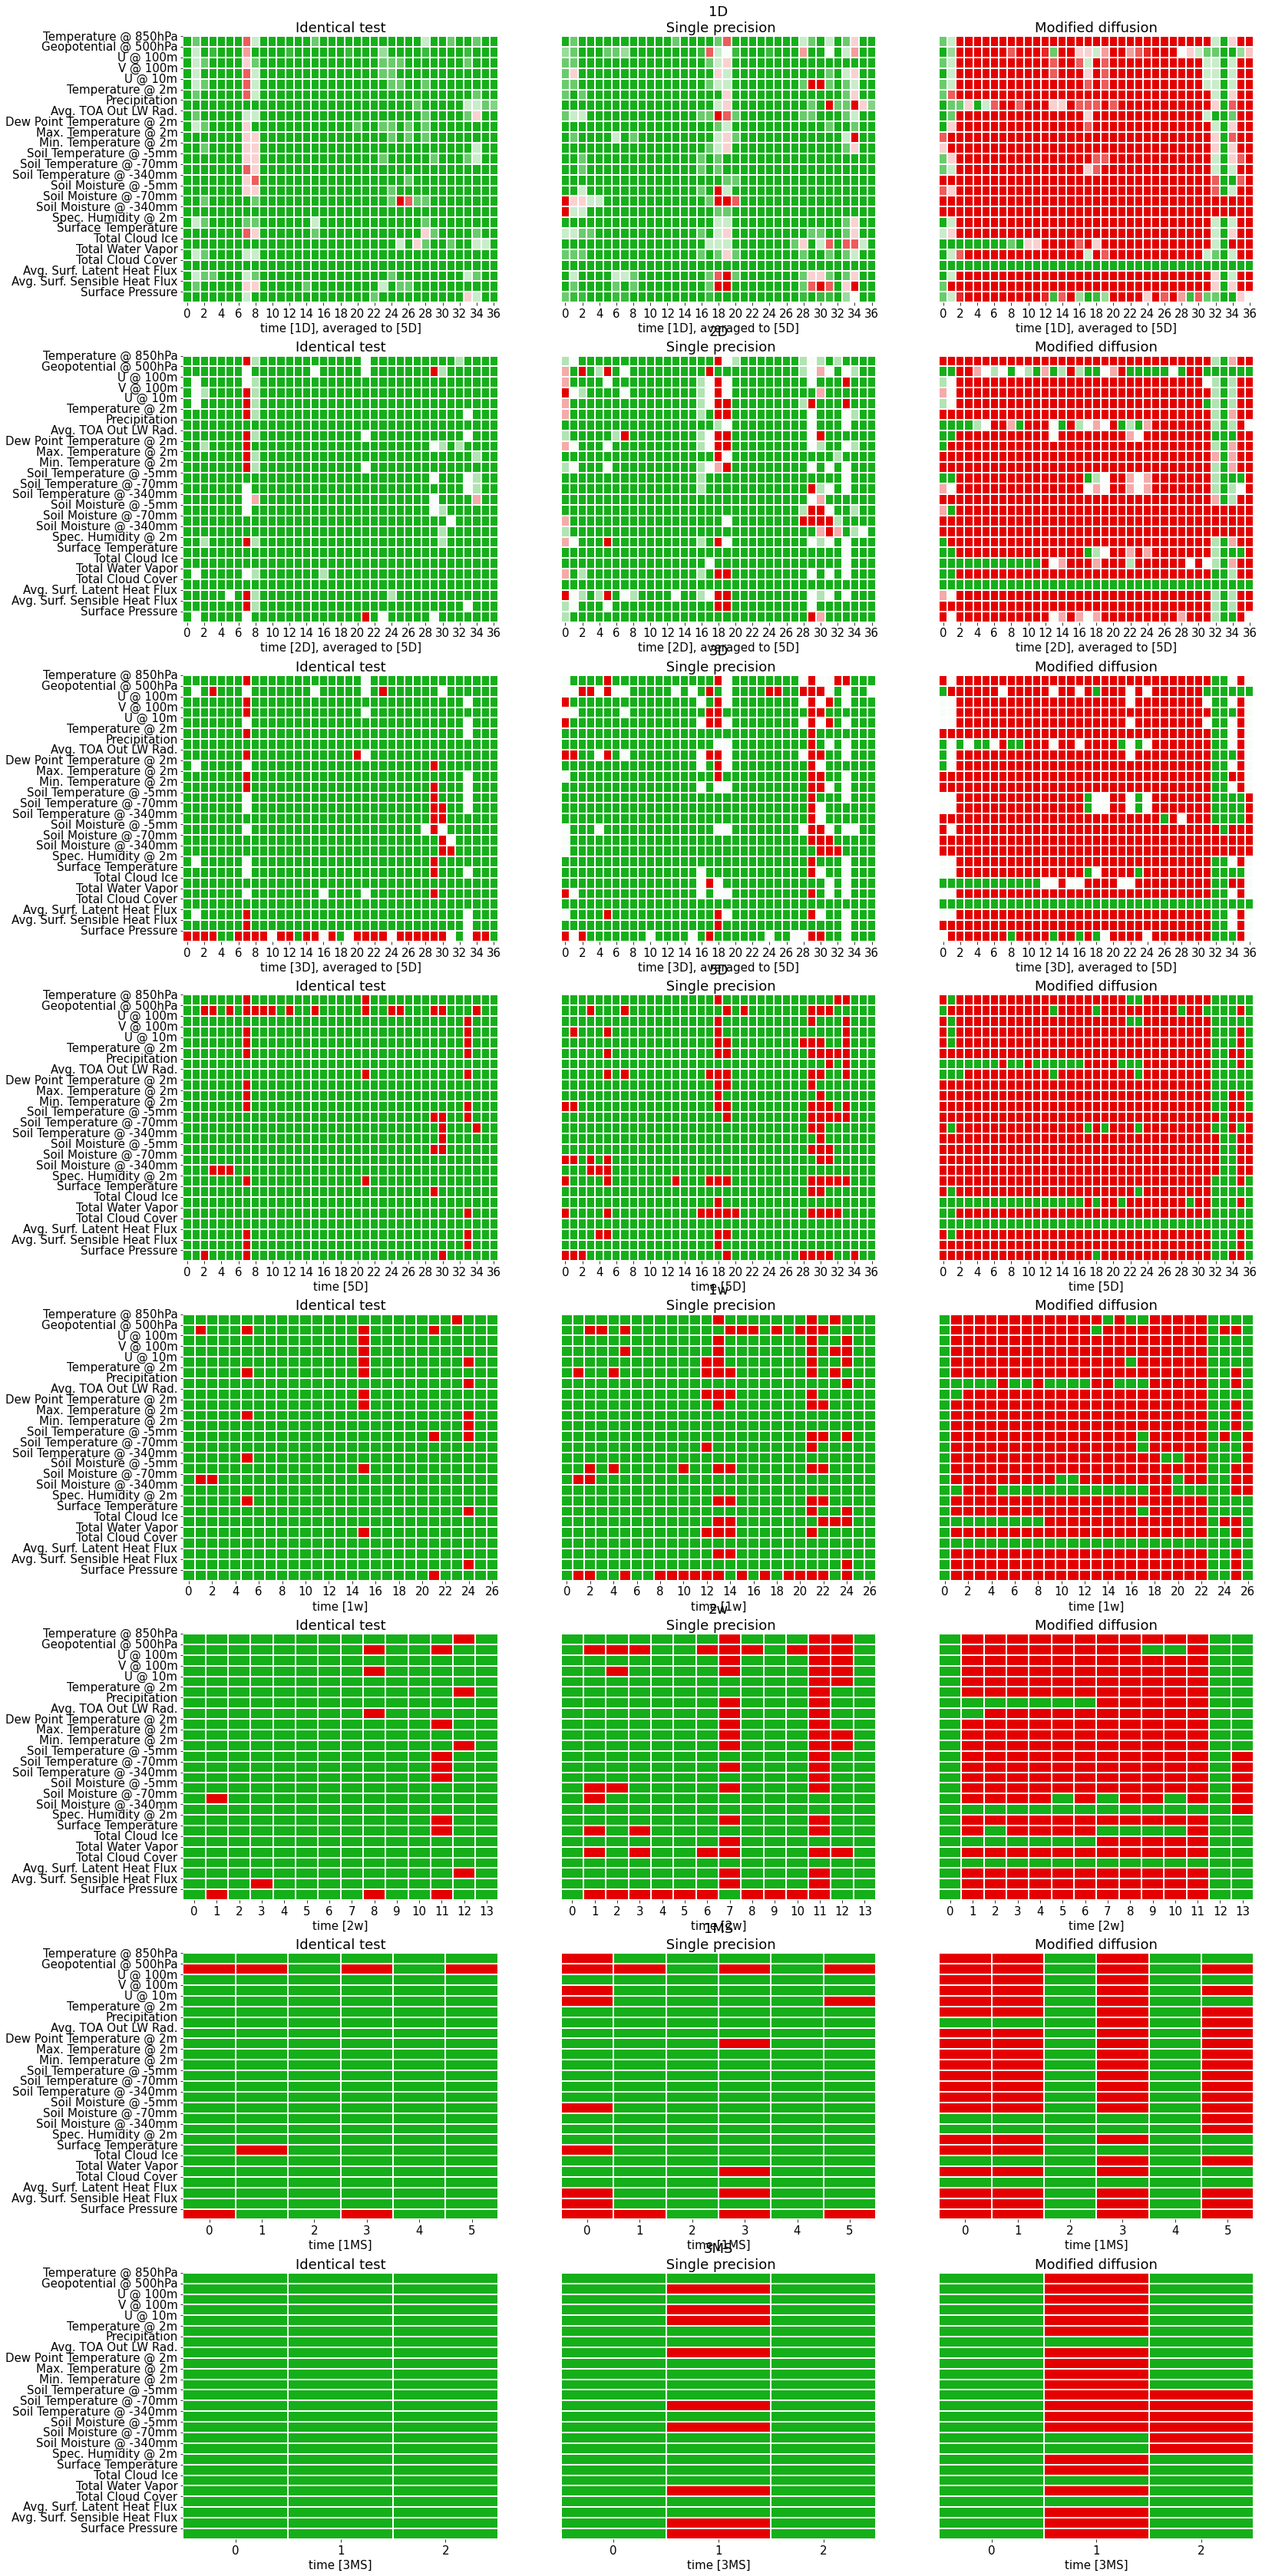

In [28]:
freqs = ["1D", "2D", "3D", "5D", "1w", "2w", "1MS", "3MS"]
factor = [1, 2, 3, 5, 7, 14, 30, 90]
semester = 19
semesterstr = "sa1998"
with open(f"{PATHBASE}/results/alldec_allfreqs_allvars_s{semesterstr}.pkl", "rb") as handle:
    decision = pkl.load(handle)

cmap=LinearSegmentedColormap.from_list(
    'rg', [
        [229 / 256, 0, 0, 1], 
        [1, 1, 1, 1], 
        [21 / 256, 176 / 256, 26 / 256, 1]
    ], N=40)
vlabels = [variablemap[key][-1] for key in variablemap]
titles = ["Identical test", "Single precision", "Modified diffusion"]
    
fig, axes = plt.subplots(8, 3, figsize=(25, 60))

crit_rej = np.linspace(0.1, 0.4, 31)
thing = np.empty((len(variablemap.keys()), len(freqs)))
c_crit = np.empty((len(variablemap.keys()), len(freqs)))
to_plot = np.empty((len(variablemap.keys()), len(freqs)), dtype=object)

x = []
for j in range(len(freqs)):
    i = 0
    x.append(np.arange(decision["t_850hPa"][j].shape[1]))
    for varname in variablemap.keys():
        avgrej = np.mean(decision[varname][j], axis=(-1, -2))
        meanrej = np.mean(avgrej[0, ..., np.newaxis] > crit_rej, axis=0)
        c_crit[i, j] = crit_rej[np.argmin(np.abs(meanrej - 0.05))]
        is12h = (j == 0 and variablemap[varname][0][:2] == "12")
        time = pd.date_range("1989-07-01", periods=avgrej.shape[-1], freq="12H" if is12h else freqs[j], inclusive="left")
        
        to_plot[i, j] = xr.DataArray(
            data=(avgrej > c_crit[i, j]),
            dims=["ensembles", "time"],
            coords=dict(
                ensembles=[0, 1, 2],
                time=time,
            ),
        )
                   
        if j < 3:
            to_plot[i, j] = to_plot[i, j].resample(time="5D").mean()
        i += 1
    
    xlabel = f"time [{freqs[j]}]" + (", averaged to [5D]" if j < 3 else "")
    for k in range(3):
        ax = axes[j, k]
        this_thing = xr.concat([to_plot[i, j][k, :] for i in range(len(variablemap))], dim="variable")
        sns.heatmap(
            1 - this_thing, linewidth=1.8, cmap=cmap, ax=ax, cbar=False, vmax=1, vmin=0
        )
        ax.set_xlabel(xlabel)
        if k == 0:
            ax.set_yticks(np.arange(len(vlabels)))
            ax.set_yticklabels(vlabels, rotation=0)
        else:
            ax.set_yticks([])
        if k == 1:
            ax.set_title(f"{freqs[j]}\n {titles[k]}")
        else:
            ax.set_title(titles[k])
plt.savefig(f"Figures/allvar_allfreqs_{semesterstr}.pdf")

In [58]:
freqs = ["1D", "2D", "3D", "5D", "1w", "2w", "1MS", "3MS"]
varname = "ashfl_s"
factor = [1, 2, 3, 5, 7, 14, 30, 90]
semester = 19
semesterstr = "sa1998"
with open(f"{PATHBASE}/results/allres_allfreqs_{varname}{semesterstr}.pkl", "rb") as handle:
    allres_allfreqs = pkl.load(handle)

quantile = 0.95
decision = []
avgdec = []
for this_allres in allres_allfreqs:
    a, b = decisions(this_allres, quantile)
    decision.append(a)
    avgdec.append(b)

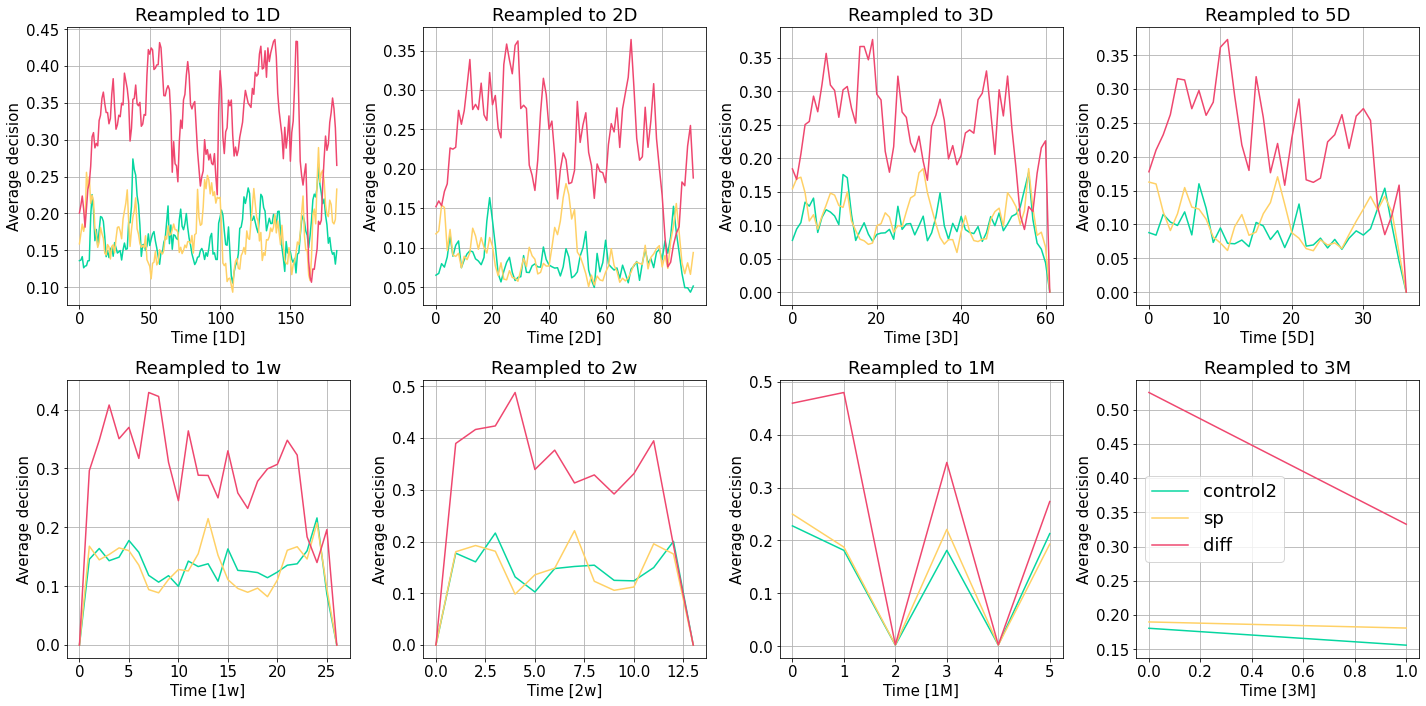

In [61]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10), tight_layout=True)
axes = axes.flatten()
labels = ["control2", "sp", "diff"]
for i in range(8):
    freq = freqs[i]
    ax = axes[i]
    for j in range(3):
        ax.plot(np.mean(decision[i][j], axis=(-2, -1)), label=labels[j], color=COLORS[2 - j])

    ax.grid(True)
    if i == 7:
        ax.legend()
    ax.set_xlabel(f"Time [{freq[:2]}]")
    ax.set_ylabel("Average decision")
    ax.set_title(f"Reampled to {freq[:2]}")

plt.savefig("Figures/resampling.pdf")

## Close look at one variable

In [21]:
freqs = ["1D", "2D", "3D", "5D", "1w", "2w", "1MS", "3MS"]
freqind = 0
freq = freqs[freqind]
varname = "clct"
semester = 1
semesterstr = "sa1989"
with open(f"{PATHBASE}/results/allres_allfreqs_{varname}{semesterstr}.pkl", "rb") as handle:
    allres = pkl.load(handle)[freqind]
with open(f"{PATHBASE}/results/alldec_allfreqs_allvars_s{semesterstr}.pkl", "rb") as handle:
    decision = pkl.load(handle)[varname][freqind]
with open(f"{PATHBASE}/results/allavgdec_allfreqs_allvars_s{semesterstr}.pkl", "rb") as handle:
    avgdec = pkl.load(handle)[varname][freqind]
bigname = variablemap[varname][1]
fname = f"{PATHBASE}/main/{varname}s{semester}.nc"
darr = xr.open_dataset(fname)[bigname].load()

/project/pr133/hbanderi/miniconda3/envs/env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'transform_first'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


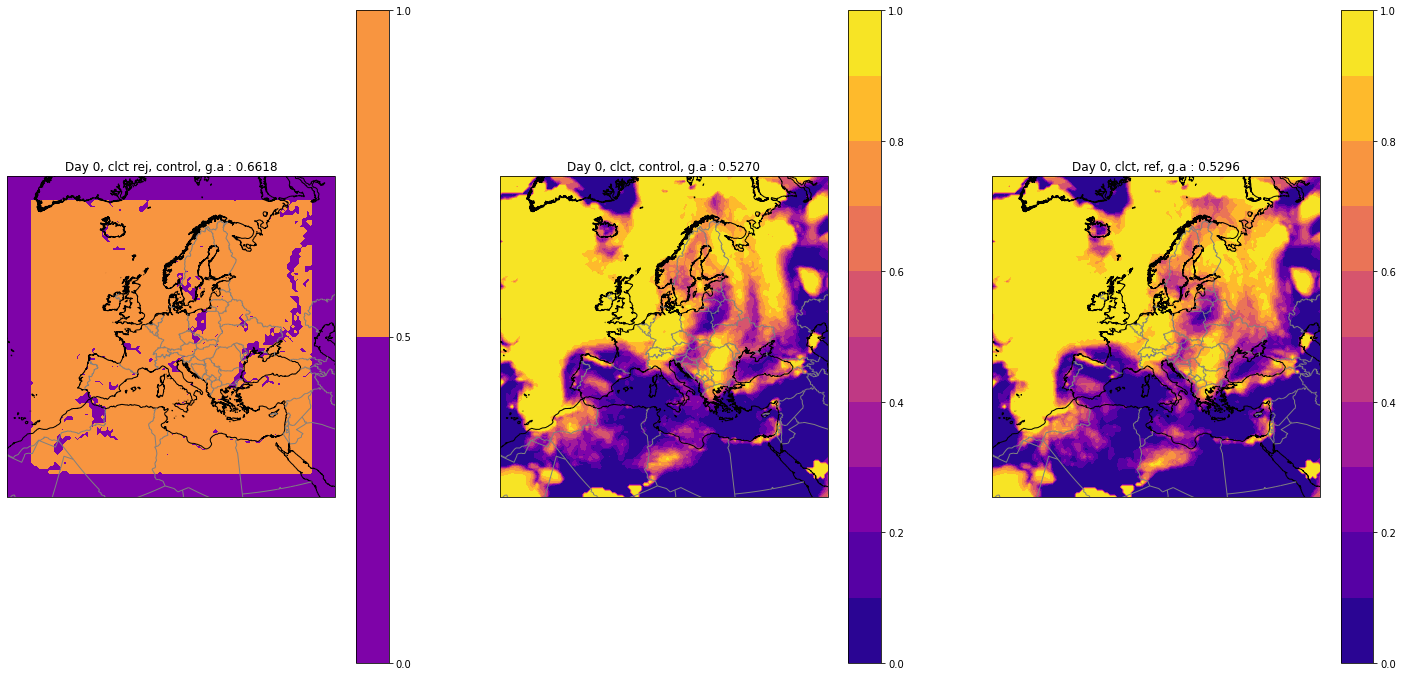

In [24]:
bs = metadata["boundary_size"]
allres2 = np.pad(allres, [[0, 0], [0, 0], [bs, bs], [bs, bs], [0, 0]])

to_plot = [
    np.mean(allres2[0, :, :, :, :], axis=-1) > 0.2,
    np.mean(darr[0], axis=-1).values,
    np.mean(darr[2], axis=-1).values,
]
titles = [
    "clct rej, control",
    "clct, control",
    "clct, ref",
]
levels = [1, 10, 10]
fig, axes, plt_rej, animate_all = create_plot(to_plot, titles, levels, False, 0)

In [25]:
anim = animation.FuncAnimation(fig, animate_all, frames=range(10), repeat=False)
disp.HTML(anim.to_jshtml())

/project/pr133/hbanderi/miniconda3/envs/env/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'transform_first'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


# Spatial coarsening

In [49]:
varname = "ashfl_s"
darr = loaddarr(varname, 19, "main", False, False, True)
freq = "1D"
n_sel = 50
alpha = 0.05
c_facs_x = [1, 2, 3, 4, 6, 27, 54, 109]
c_facs_y = [1, 2, 3, 4, 7, 28, 56, 112]
f = IntProgress(min=0, max=n_sel * len(c_facs_x))  # instantiate the bar
display(f)  # display the bar
pouet = [0, 1, 3, 4]
allres_all_c_facs = []
for i in range(len(c_facs_x)):
    c_fac_x = c_facs_x[i]
    c_fac_y = c_facs_y[i]
    d_crit = np.sqrt(-np.log(alpha / 2) / n_sam[freq])
    ti = timer.time()
    darrr = oversample(darr.coarsen({"rlat": c_fac_x, "rlon": c_fac_y}, boundary="trim").mean(), freq)
    print(f"Coarsen {c_fac_x} and {c_fac_y} times : {(timer.time() - ti):.2f} s")
    darrcp = cp.asarray(darrr)
    allres = np.empty((len(pouet), *darrr.shape[1:4], n_sel), dtype=bool)
    for s in range(n_sel):
        allres[..., s] = cupy_ks(darrcp, pouet, ref, n_sam[freq], replace, d_crit).get()
        f.value += 1
    allres_all_c_facs.append(allres)  # all different shape

IntProgress(value=0, max=400)

Coarsen 1 and 1 times : 5.53 s
Coarsen 2 and 2 times : 3.63 s
Coarsen 3 and 3 times : 2.87 s
Coarsen 4 and 4 times : 2.54 s
Coarsen 6 and 7 times : 2.34 s
Coarsen 27 and 28 times : 1.98 s
Coarsen 54 and 56 times : 1.92 s
Coarsen 109 and 112 times : 1.89 s


In [50]:
with open("/scratch/snx3000/hbanderi/data/results/allres_all_c_facs_ashfl_ssa1998.pkl", "wb") as handle:
    pkl.dump(allres_all_c_facs, handle)

In [51]:
# fig, axes = plt.subplots(2, 4, figsize=(20, 13))
# axes = axes.flatten()
final_spatial = []
# labels = ["control2", "sp", "diff"]
# crit_rej = np.linspace(0.01, 0.3, 30)
for i in range(len(allres_all_c_facs)):
    this_allres = allres_all_c_facs[i].astype(float)
    this_final = np.mean(this_allres[1:, ...], axis=-1) > np.quantile(this_allres[0, ...], 0.95, axis=-1)
    final_spatial.append(this_final)
    # results = np.mean(this_allres, axis=(2, 3)).transpose((2, 0, 1))
    # final2 = np.mean(this_final, axis=(2, 3))
    # meanrej = np.mean(final2[:, :, np.newaxis] > crit_rej, axis=1)
    # ax = axes[i]
    # for j in range(3):
    #     ax.plot(crit_rej, meanrej[j], label=labels[j])
    # ax.grid(True)
    # ax.set_xlabel("Critical rejection rate")
    # ax.set_ylabel("Decision rate")
    # ax.legend()
    # ax.set_title(freqs[i])
    # ax.set_ylim([-0.025, 1.025])

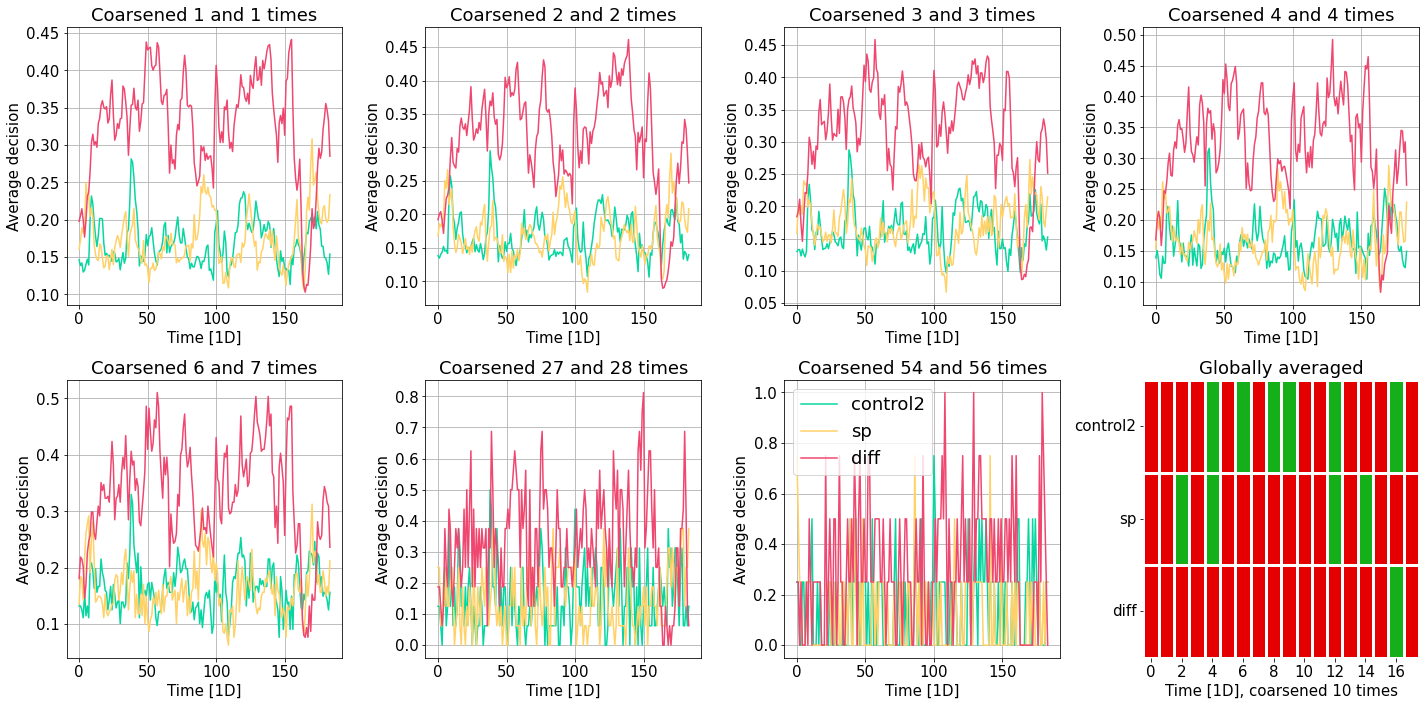

In [63]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10), tight_layout=True)
axes = axes.flatten()
labels = ["control2", "sp", "diff"]
freq = "1D"
for i in range(7):
    ax = axes[i]
    for j in range(3):
        ax.plot(np.mean(final_spatial[i][j], axis=(-2, -1)), label=labels[j], color=COLORS[2 - j])

    ax.grid(True)
    if i==6:
        ax.legend()
    ax.set_xlabel(f"Time [{freq}]")
    ax.set_ylabel("Average decision")
    ax.set_title(f"Coarsened {c_facs_x[i]} and {c_facs_y[i]} times")
    
ax = axes[-1]  # special treatment for the last
cmap = mpl.cm.get_cmap("RdYlGn", 2)
newcolors = cmap(np.linspace(0, 1, 2))
newcolors[-1, :] = [21 / 256, 176 / 256, 26 / 256, 1]
newcolors[0, :] = [229 / 256, 0, 0, 1]
cmap = mpl.colors.ListedColormap(newcolors)
to_plot = 1 - final_spatial[-1][:, :, 0, 0]
coarseness = 10
trimmed_len = int(np.floor(to_plot.shape[1] / coarseness) * coarseness)
bizarrent = to_plot[:, :trimmed_len].reshape(to_plot.shape[0], int(np.floor(to_plot.shape[1] / coarseness)), coarseness)
to_plot = np.mean(bizarrent, axis=-1)
sns.heatmap(
    to_plot > (coarseness - 1)/coarseness, linewidth=1.1, cmap=cmap, ax=ax, cbar=False, vmax=1, vmin=0
)
ax.set_xlabel(f"Time [{freq}], coarsened {coarseness} times")
ax.set_title("Globally averaged")
ax.set_yticklabels(labels, rotation=0)
plt.savefig("coarsening.pdf")

In [30]:
distance_spatial = np.empty((len(c_facs_x), 2))
for i in range(len(freqs)):
    distance_spatial[i, 0] = np.mean(np.mean(final_spatial[i][2], axis=(-2, -1)) - np.mean(final_spatial[i][0], axis=(-2, -1)))
    distance_spatial[i, 1] = np.mean(np.mean(final_spatial[i][1], axis=(-2, -1)) - np.mean(final_spatial[i][0], axis=(-2, -1)))
print(distance_spatial)

[[ 0.11232681  0.02906174]
 [ 0.10955215  0.01811697]
 [ 0.08912484  0.01882239]
 [ 0.07917611  0.00916478]
 [ 0.08407738  0.00520833]
 [ 0.0625      0.08035714]
 [-0.03571429 -0.03571429]
 [ 0.          0.        ]]


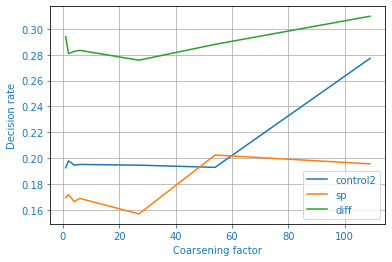

In [ ]:
global_average = np.array([[np.mean(final_spatial[i][j]) for j in range(3)] for i in range(len(c_facs_x))])
fig, ax = plt.subplots()
labels = ["control2", "sp", "diff"]
for i in range(3):
    ax.plot(c_facs_x, global_average[:, i], label=labels[i])
ax.grid(True)
ax.set_xlabel("Coarsening factor")
ax.set_ylabel("Decision rate")
ax.legend()

# Other random tests

## Random test 1 : when to global average

two ways to get a sense of the internal variability of an ensemble. Here we use the specific heat flux at the surface because it is causing problems later down the track (see end)
We can either space-average and then compute the std of this time series (blue line) or compute the std on each gridpoint and space-average it (red line). As expected the red line is always much higher than the blue

/apps/daint/UES/jenkins/7.0.UP03/21.09/daint-gpu/software/jupyterlab/3.2.8-CrayGNU-21.09-batchspawner-cuda/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


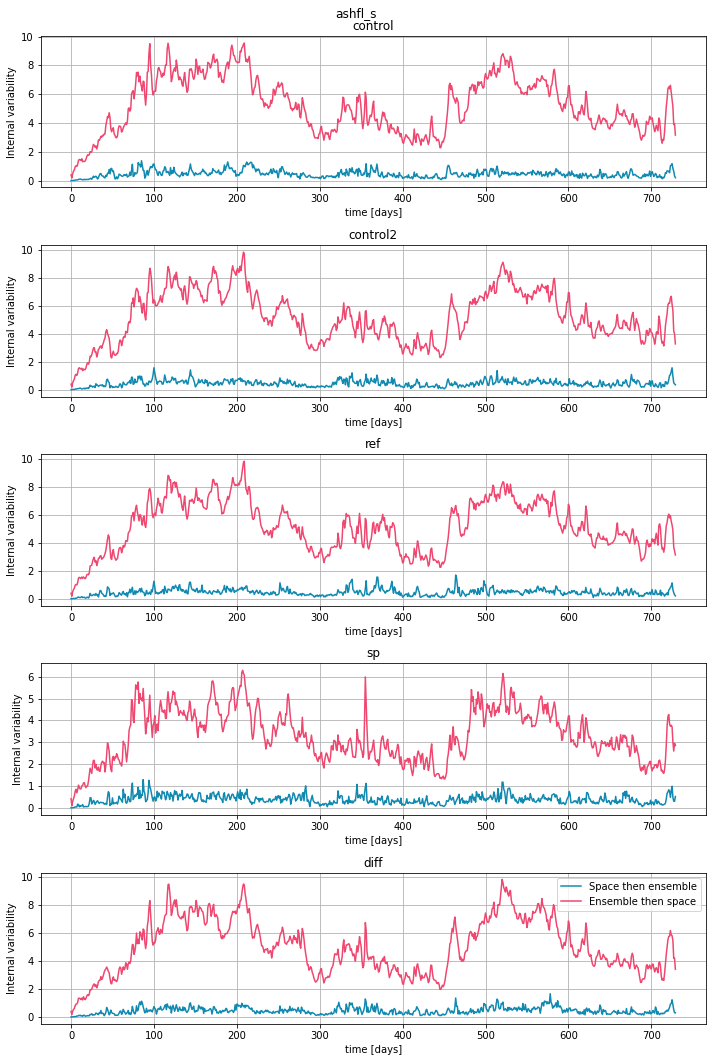

In [5]:
varname = "ashfl_s"
i = 0
at_once = 4
bigname = variablemap[varname][1]
fnames = [f"{PATHBASE}/main/{varname}s{j}.nc" for j in range(i, i + at_once)]
darr = xr.open_mfdataset(fnames)[bigname]

fig, axes = plt.subplots(darr.shape[0], 1, tight_layout=True, figsize=(10, 15))
x = np.arange(darr.shape[1])
colors = ["#073B4C", "#118ab2", "#06D6A0", "#ffd166", "#ef476f"]
fig.suptitle(varname)
for i in range(darr.shape[0]):
    ax = axes[i]
    ax.plot(
        x,
        np.std(np.mean(darr[i, ...], axis=(1, 2)), axis=-1),
        color=colors[1],
        label="Space then ensemble",
    )
    ax.plot(
        x,
        np.mean(np.std(darr[i, ...], axis=-1), axis=(1, 2)),
        color=colors[-1],
        label="Ensemble then space",
    )
    ax.grid(True)
    ax.set_xlabel("time [days]")
    ax.set_ylabel("Internal variability")
    ax.set_title(ensembles[i])

axes[-1].legend()

## Random test 2 : effects of the oversampling on the internal variability

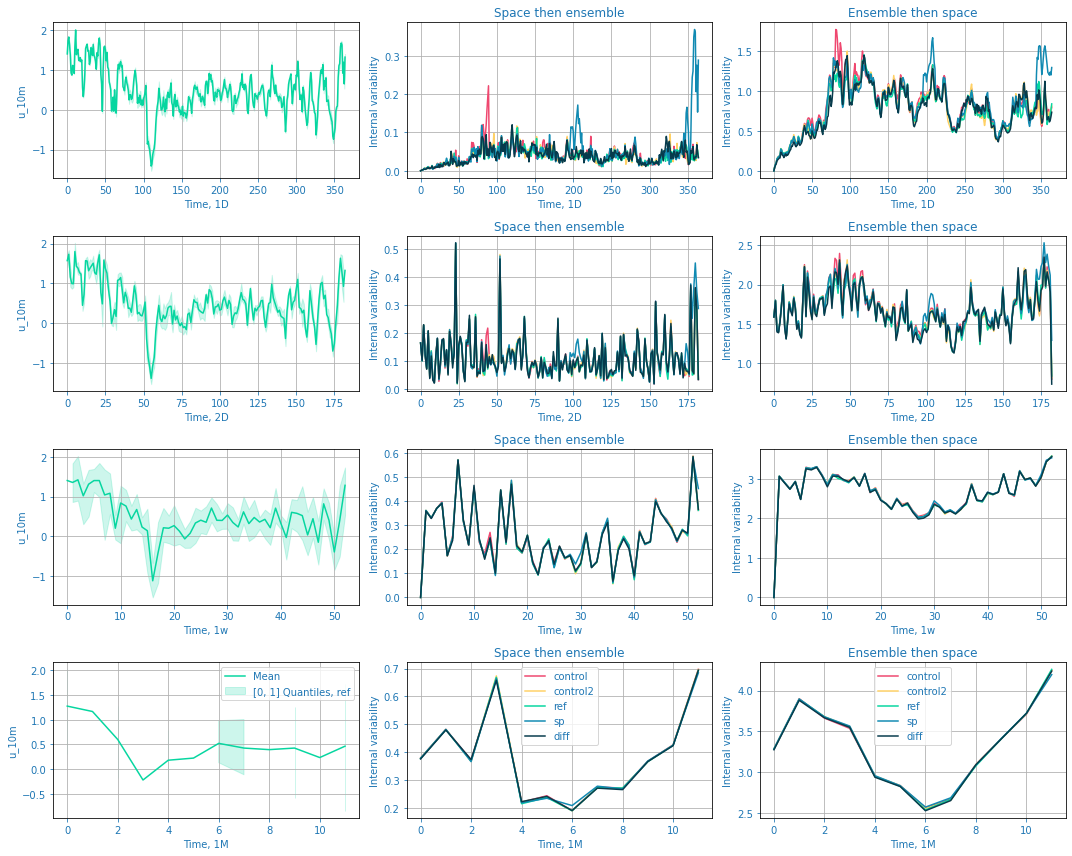

In [24]:
darr = loaddarr("u_10m", [0, 1], "main", False, True, True)
freqs = ["1D", "2D", "1w", "1M"]
fig, axes = plt.subplots(len(freqs), 3, tight_layout=True, figsize=(15, 12))
dims = list(darr.dims)
colors = ["#EF476F", "#FFD166", "#06D6A0", "#118AB2", "#073B4C"]
for i in range(len(freqs)):
    freq = freqs[i]
    newdarr = oversample(darr, freq)
    x = np.arange(len(newdarr["newtime"]))
    axes[i, 0].plot(
        x, np.mean(newdarr[2, ...], axis=(1, 2, 3)), color=colors[2], label="Mean"
    )
    axes[i, 0].fill_between(
        x,
        *np.quantile(np.mean(newdarr[2, ...], axis=(1, 2)), [0, 1], axis=-1),
        color=colors[2],
        alpha=0.2,
        label=f"[0, 1] Quantiles, {ensembles[2]}",
    )
    axes[i, 0].set_ylabel(varname)
    for j in range(newdarr.shape[0]):
        axes[i, 1].plot(
            x,
            np.std(np.mean(newdarr[j, ...], axis=(1, 2)), axis=-1),
            color=colors[j],
            label=ensembles[j],
        )
        axes[i, 1].set_title("Space then ensemble")
        axes[i, 1].set_ylabel("Internal variability")
        axes[i, 2].plot(
            x,
            np.mean(np.std(newdarr[j, ...], axis=-1), axis=(1, 2)),
            color=colors[j],
            label=ensembles[j],
        )
        axes[i, 2].set_title("Ensemble then space")
        axes[i, 2].set_ylabel("Internal variability")
    for ax in axes[i, :]:
        ax.set_xlabel(f"Time, {freqs[i]}")
        ax.grid(True)
axes[-1, 0].legend()
axes[-1, 1].legend()
axes[-1, 2].legend()

## Time-autocorrelation of all variables

To justify oversampling, we compute the time-autocorrelation of all the variables in the reference ensemble. We also compute the average lag after which it goes below $1 \over e$ The results are that most of the variables stay correlated after a month or even two, while a few (u_100m for example) stop being correlated after only 2 days.

In [ ]:
fig, axes = plt.subplots(8, 6, tight_layout=True, figsize=(20, 30))
axes = axes.flatten()
wo = {}
for i, varname in enumerate(variablemap.keys()):
    wo[varname] = []
    ax = axes[i]
    bigname = variablemap[varname][1]
    darr = loaddarr(varname, np.arange(12), "main", True, True, False)
    series = np.mean(darr[2, :, :, :, 0], axis=(1, 2))
    mean = np.mean(series)
    s = 1
    N = len(series)
    howmany = 200  # N - s
    autocorr = np.empty((howmany))
    for k in range(len(autocorr)):
        autocorr[k] = np.sum((series[k:] - mean) * (series[: N - k] - mean))
    autocorr = autocorr / autocorr[0]
    ax.set_title(varname)
    ax.set_xlabel("Time lag [days]")
    ax.set_ylabel("Autocorrelation")
    ax.grid(True)
    wo[varname].append(np.where(autocorr < 1 / np.e)[0][0])
    # ax.vlines(wo, 0, 1, "k")
    ax.plot(np.arange(len(autocorr)), autocorr, label=f"Below at $t={wo[varname][0]}$")

    series = darr[2, :, :, :, 0]
    N = series.shape[0]
    s = 1
    mean = np.tensordot(np.ones(N), np.mean(series, axis=0), axes=0)
    autocorr = np.empty((howmany, darr.shape[2], darr.shape[3]))
    for k in range(autocorr.shape[0]):
        autocorr[k] = np.sum(
            (series[k:] - mean[k:]) * (series[: N - k] - mean[: N - k]), axis=0
        )
    to_plot = np.nanmean(
        autocorr / np.tensordot(np.ones(howmany), autocorr[0], axes=0), axis=(1, 2)
    )

    wo[varname].append(np.where(to_plot < 1 / np.e)[0][0])
    ax.plot(np.arange(howmany), to_plot, label=f"Below at $t={wo[varname][1]}$")
    ax.legend()

/tmp/ipykernel_343/1155166778.py:8: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  darr = loaddarr(varname, np.arange(12), "main", True, True, False)
/tmp/ipykernel_343/1155166778.py:8: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_larg

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1553e022ba60> (for post_execute):


## Random test 3 : KS made explicit

When performing the KS test, we compare two empirical cumulative distributions. We pick 50 grid and time points at random, plot the two cumulative functions, corresponding to the ref and control ensembles, for each of these points.
1000 each, no tie check : 300 ms (1.8 when cached, sometimes 70ms)

In [16]:
def ks_cumsum(a, b):
    x = cp.concatenate([a, b], axis=-1) # Concat all data
    nx = cp.sum(~cp.isnan(a), axis=-1) # Sum of nonnan instead of length to get actual number of samples, because time-oversampling may give you nans in the time axis
    idxs_ks = cp.argsort(x, axis=-1)
    x = cp.take_along_axis(x, idxs_ks, axis=-1) # The x-axis of the ks plots, take_along_axis instead of sorting again. I need it to check for too close values, and problems with sp
    nx = nx[..., cp.newaxis] # Will need to be cast against a 4d array 
    # Cumulative distribution function using cumsum. The indices inferior to nx come from a the others come from b. 
    # Creates y1 (y2) the following way : for each other axis, iterates over the data in the member axis and adds 1/nx everytime it hits a value coming from a (b).
    y1 = cp.cumsum(idxs_ks < nx, axis=-1) / nx 
    y2 = cp.cumsum(idxs_ks >= nx, axis=-1) / nx
    # If the ks distance is found at 0 or 1, there probably is a rounding error problem. This could be made faster I think.
    ds = cp.abs(y1 - y2)
    return cp.amax(ds, axis=-1)


def searchsortednd(a, x):  # https://stackoverflow.com/questions/40588403/vectorized-searchsorted-numpy
    orig_shape = a.shape[:-1]
    a = a.reshape(np.prod(orig_shape), -1)
    x = x.reshape(np.prod(orig_shape), -1)
    m, n = a.shape
    max_num = cp.maximum(a.max() - a.min(), x.max() - x.min()) + 1
    r = max_num * cp.arange(a.shape[0])[:, None]
    p = cp.searchsorted((a + r).ravel(), (x + r).ravel()).reshape(m,-1)
    return (p - n * (cp.arange(m)[:, None])).reshape((*orig_shape, -1))


def ks_customss(a, b):
    a, b = cp.sort(a, axis=-1), cp.sort(b, axis=-1)
    nx = cp.sum(~cp.isnan(a), axis=-1)[..., cp.newaxis]
    x = cp.concatenate([a, b], axis=-1) # Concat all data
    y1 = searchsortednd(a, x) / nx
    y2 = searchsortednd(b, x) / nx
    ds = cp.abs(y1 - y2)
    return cp.amax(ds, axis=-1)

### compare new implementation

In [66]:
varname = "clct"
ana = "main"
darr = loaddarr(varname, variablemap[varname][1], ensembles[ana], 12, ana="main", big=True, values=True, bs=metadata["boundary_size"])
a = cp.asarray(darr[3, :2])
b = cp.asarray(darr[2, :2])

In [67]:
impl = {
    "ks_cumsum" : ks_cumsum,
    "ks_customss": ks_customss
}
results = {}
for key, value in impl.items():
    print(key)
    results[key] = [result.get() for result in value(a, b)]

ks_cumsum
ks_customss


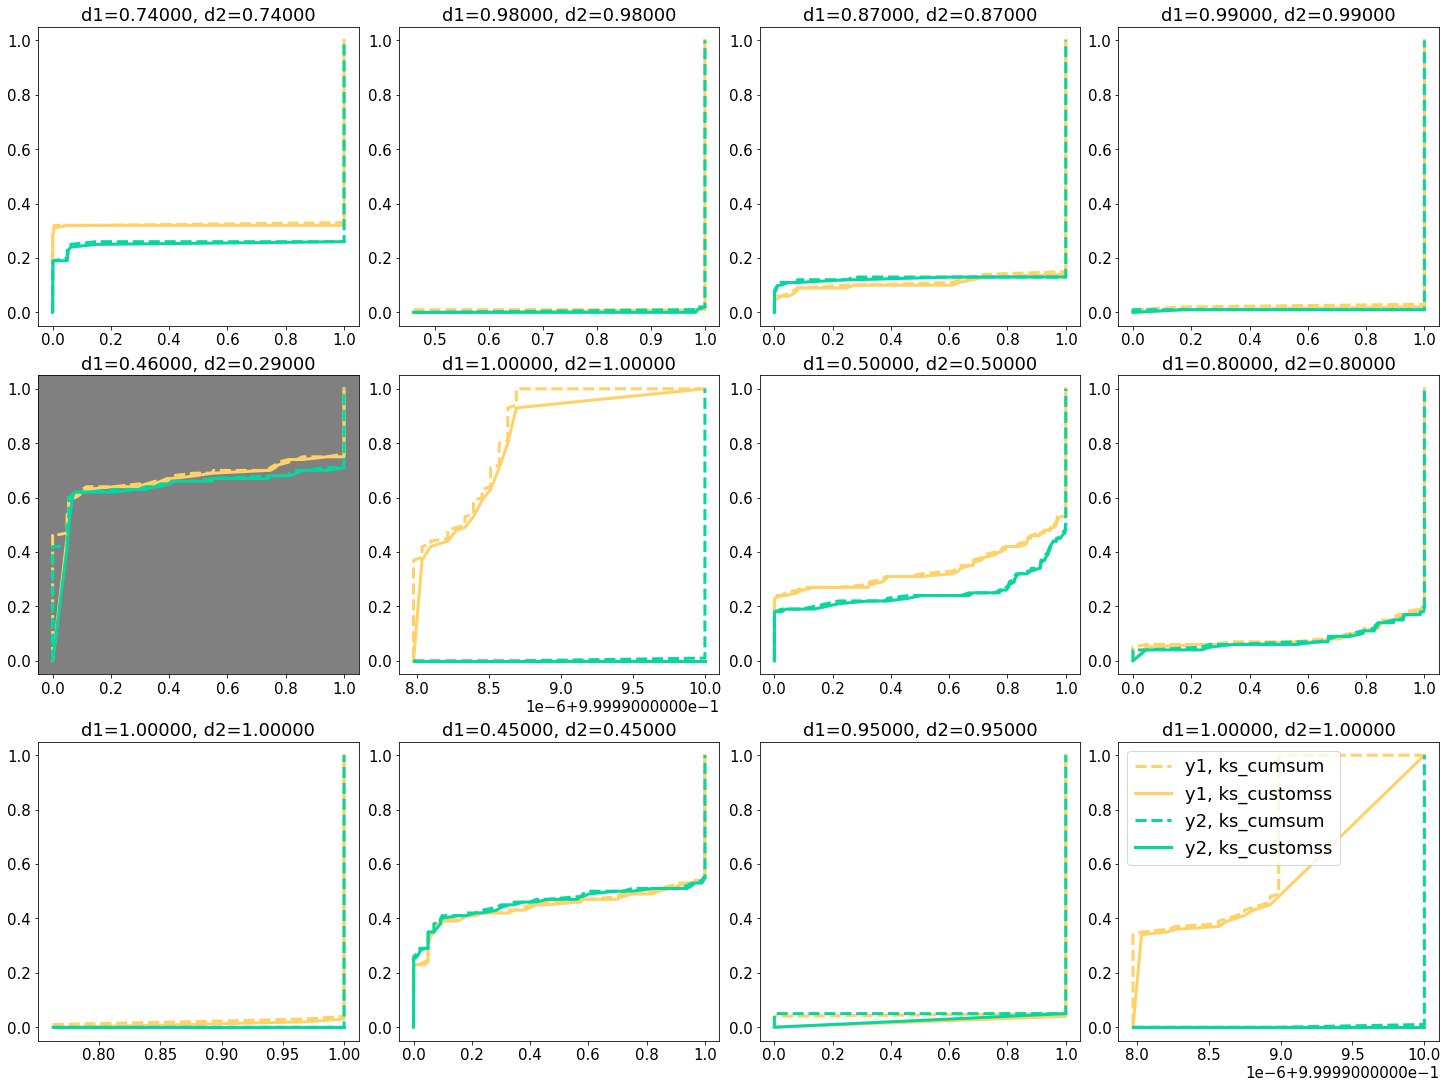

In [68]:
fig, axes = plt.subplots(3, 4, constrained_layout=True, figsize=(20, 15))
axes = np.atleast_1d(axes)
# fig.suptitle("Reference vs. Control, at random points")
axes = axes.flatten()
for s in range(len(axes)):
    where = [np.random.randint(j) for j in a.shape[:3]]
    y11 = results["ks_cumsum"][1][where[0], where[1], where[2]]
    y21 = results["ks_cumsum"][2][where[0], where[1], where[2]]
    x1 = results["ks_cumsum"][-1][where[0], where[1], where[2]]
    y12 = results["ks_customss"][1][where[0], where[1], where[2]]
    y22 = results["ks_customss"][2][where[0], where[1], where[2]]
    x2 = results["ks_customss"][-1][where[0], where[1], where[2]]
    d1 = results["ks_cumsum"][0][where[0], where[1], where[2]]
    d2 = results["ks_customss"][0][where[0], where[1], where[2]]
    argx2 = np.argsort(x2)
    x2 = x2[argx2]
    y12 = y12[argx2]
    y22 = y22[argx2]
    ax = axes[s]
    ax.plot(x1, y11, color=COLORS[1], lw=3, ls="dashed", label="y1, ks_cumsum")
    ax.plot(x2, y12, color=COLORS[1], lw=3, label="y1, ks_customss")
    ax.plot(x1, y21, color=COLORS[2], lw=3, ls="dashed", label="y2, ks_cumsum")
    ax.plot(x2, y22, color=COLORS[2], lw=3, label="y2, ks_customss")
    ax.set_title(f"d1={d1:.5f}, d2={d2:.5f}")
    if s == len(axes) - 1:
        ax.legend()
    if not(np.isclose(d1, d2)):
        ax.set_facecolor("gray")

In [69]:
np.sum(~np.isclose(results["ks_cumsum"][0], results["ks_customss"][0])) / np.prod(results["ks_customss"][0].shape)

0.23791775884665792

### FDR

In [92]:
bs = metadata["boundary_size"]
ana = "main"
freq = "1D"
test = "KS"
varname = "clct"
actualfreq = "12h" if (freq == "1D" and variablemap[varname][0][:2] == "12") else freq
coords = coords_avgdecs(varname, ana, actualfreq, ensembles_in_decisions[ana])
shape = [len(x) for x in coords.values()]
decisions = {
    "old" : xr.DataArray(np.zeros(shape), coords=coords),
    "new" : xr.DataArray(np.zeros(shape), coords=coords),
}
bigname = variablemap[varname][1]
alpha_FDR = 0.1
alpha_global = 0.05
j = 0
for k in range(N_MONTHS):
    darr = loaddarr(varname, bigname, ensembles[ana], k, ana, big=True, values=False, bs=bs)
    p = {
        "old" : cp.zeros((len(ensembles_in_decisions[ana]), *darr.shape[1:4])),
        "new" : cp.zeros((len(ensembles_in_decisions[ana]), *darr.shape[1:4])),
    }
    b = cp.asarray(darr.sel(ensemble="ref").values)
    for i, ens in enumerate(ensembles_in_decisions[ana]):
        a = cp.asarray(darr.sel(ensemble=ens))
        p["new"][i] = ks(a, b)
        p["old"][i] = ks_cumsum(a, b)
    l = j + darr.shape[1]
    for key, thisp in p.items():
        thisp = ks_p(thisp, darr.shape[-1])  # recycling yay
        thisp = cp.sort(thisp.reshape((thisp.shape[0], thisp.shape[1], thisp.shape[2] * thisp.shape[3])), axis=-1)
        thisp = thisp <= cp.arange(1, thisp.shape[-1] + 1) / thisp.shape[-1] * alpha_FDR
        decisions[key][:, j:l] = ((thisp.shape[-1] - cp.argmax(thisp[:, :, ::-1], axis=-1)) / thisp.shape[-1]).get()
    j = l
    cp.cuda.Device().synchronize()
decisions.to_netcdf(f"{PATHBASE}/results/{ana}_{freq}/FDR_decisions_{test}_{varname}.nc")

In [95]:
for key, decision in decisions.items():
    decision.to_netcdf(f"{PATHBASE}/results/{ana}_{freq}/FDR_decisions_{test}_{varname}_{key}.nc")

In [96]:
to_plot = xr.concat(
    [(1 - thisdec.sel(ensemble=ens)).resample(time="1MS").mean() for key, thisdec in decisions.items() for ens in ensembles_in_decisions[ana]],
    dim="newdim",
).assign_coords({"newdim": [f"{ens}_{key}" for key in decisions for ens in ensembles_in_decisions[ana]]})

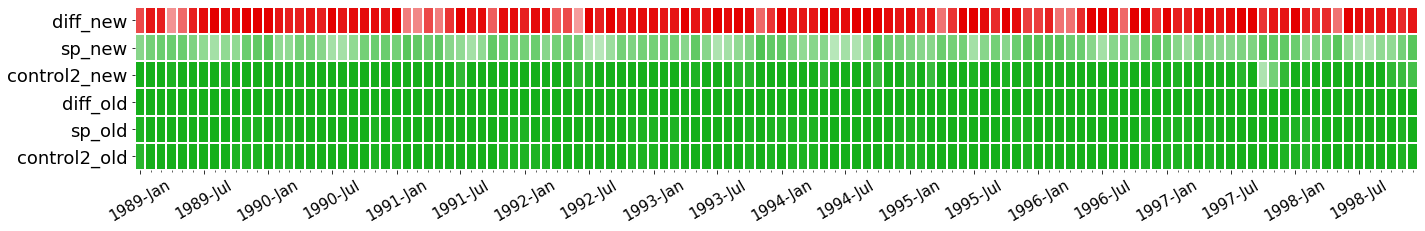

In [97]:
fig, ax = plt.subplots(figsize=(23, 3))
for spine in ax.spines.values():
    spine.set_visible(False)
ax.pcolormesh(to_plot.time, np.arange(to_plot.shape[0]), to_plot.values, cmap=CMAP, shading='nearest', vmax=1, vmin=0, rasterized=True, linewidth=1.8, edgecolors="white")
ax.xaxis_date()
ax.set_yticks(np.arange(to_plot.shape[0]))
ax.set_yticklabels(to_plot.coords["newdim"].values, rotation=0, fontsize=18)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
for tick in ax.get_xticklabels():
    tick.set_rotation(30)

### Nice plots with old implementation

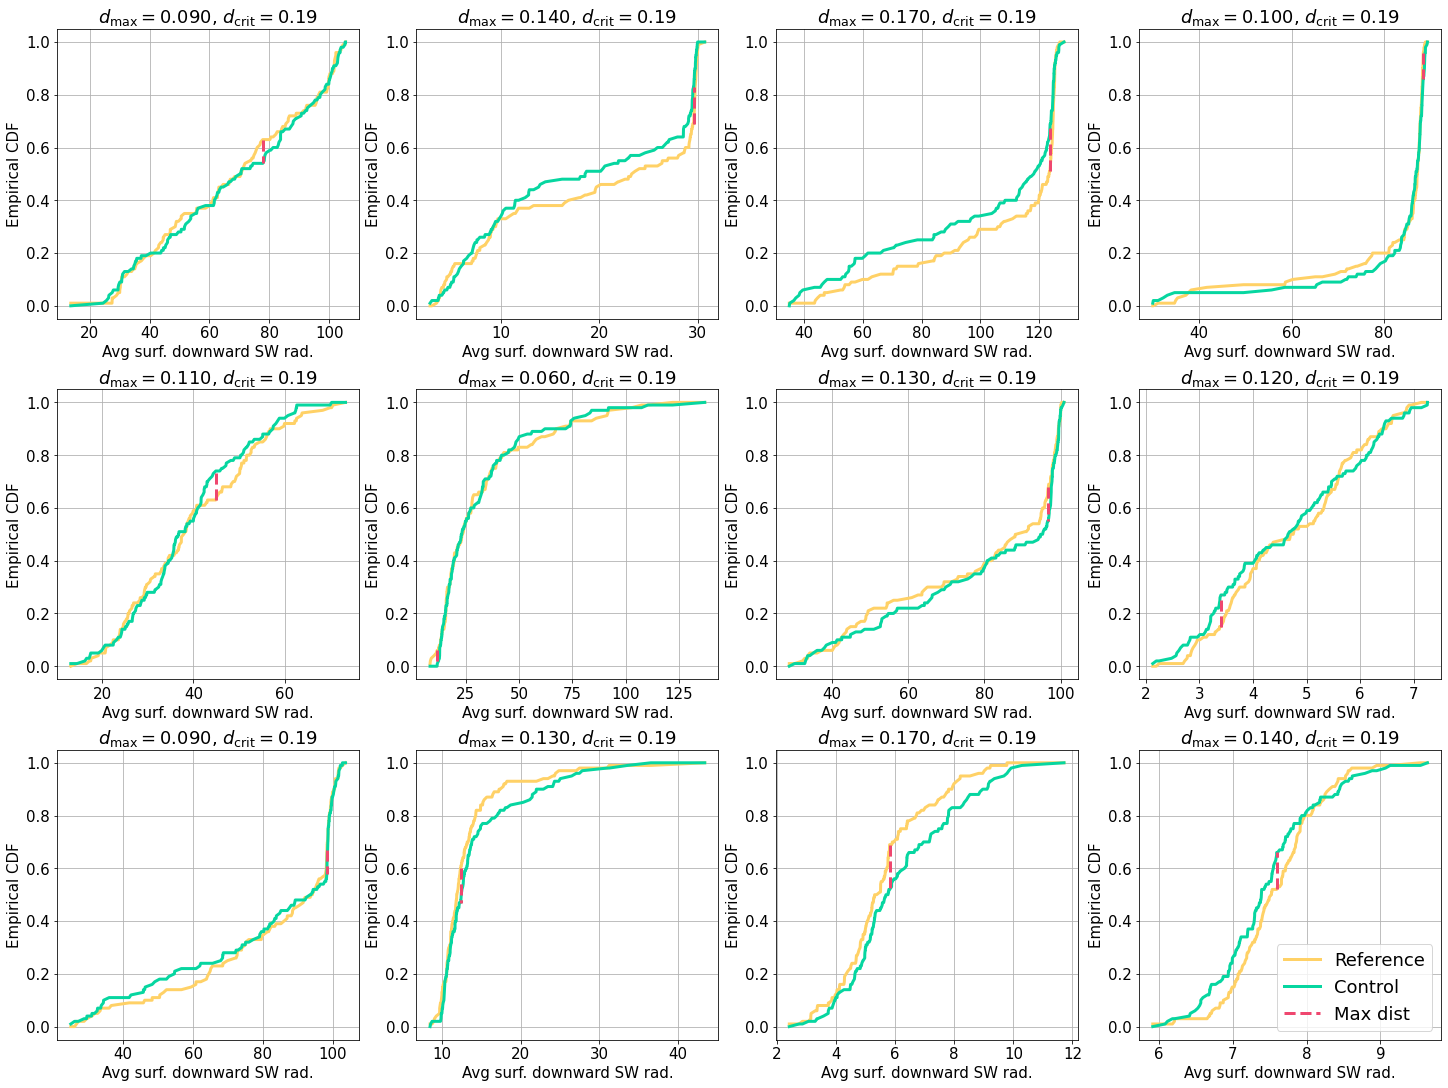

In [22]:
# dask.config.set({"array.slicing.split_large_chunks": True})
fig, axes = plt.subplots(3, 4, constrained_layout=True, figsize=(20, 15))
axes = np.atleast_1d(axes)
# fig.suptitle("Reference vs. Control, at random points")
axes = axes.flatten()
for s in range(len(axes)):
    where = [np.random.randint(j) for j in darr.shape[1:4]]
    b = darr[ref[ana], where[0], where[1], where[2], :]
    a = darr[notref[ana][0], where[0], where[1], where[2], :]
    x = np.concatenate([a, b], axis=-1)

    idxs_ks = np.argsort(x, axis=-1)
    x = np.take_along_axis(x, idxs_ks, axis=-1)
    valx = np.sum(~np.isnan(a))
    y1 = np.cumsum(idxs_ks < valx, axis=-1) / valx
    y2 = np.cumsum(idxs_ks >= valx, axis=-1) / valx
    invalid_idx = np.logical_or(np.isclose(x, 0), np.isclose(x, 1))
    ds = np.abs(y1[: 2 * valx] - y2[: 2 * valx])
    ds[invalid_idx] = 0
    dind = np.argmax(ds)
    d = ds[dind]
    rej = d > c_alpha * np.sqrt(2 / valx)
    ax = axes[s]
    if rej:
        ax.set_facecolor("gray")
    # ax.set_xlim([-0.1, 1.1])
    # ax2 = ax.twinx()
    ax.plot(x, y1, color=COLORS[1], lw=3, label="Reference")
    ax.plot(x, y2, color=COLORS[2], lw=3, label="Control")
    ax.plot([x[dind], x[dind]], [y1[dind], y2[dind]], "--", color=COLORS[0], label="Max dist", lw=3)
    # ax2.hist(a, bins=np.linspace(-0.025, 1.025, 23), alpha=0.1, facecolor=COLORS[1], edgecolor=COLORS[1], align="mid")
    # ax2.hist(b, bins=np.linspace(-0.025, 1.025, 23), alpha=0.1, facecolor=COLORS[2], edgecolor=COLORS[2], align="mid")
    # ax2.hist(a, bins=np.linspace(-0.025, 1.025, 23), alpha=1, fill=False, edgecolor=COLORS[1], align="mid")
    # ax2.hist(b, bins=np.linspace(-0.025, 1.025, 23), alpha=1, fill=False, edgecolor=COLORS[2], align="mid")
    ax.set_title(
        "$d_{\mathrm{max}}=" + f"{d:.3f}$, " + r"$d_{\mathrm{crit}}" + f"={c_alpha * np.sqrt(2 / valx):.2f}$"
    )
    ax.set_xlabel(variablemap[varname][-1])
    ax.set_ylabel("Empirical CDF")
    ax.grid(True)
    if s == (len(axes) - 1):
        ax.legend()
plt.savefig("Figures/KS_t_850hPa.png", dpi=300)

# Final results

## Local decision then average

In [6]:
ana = "main"

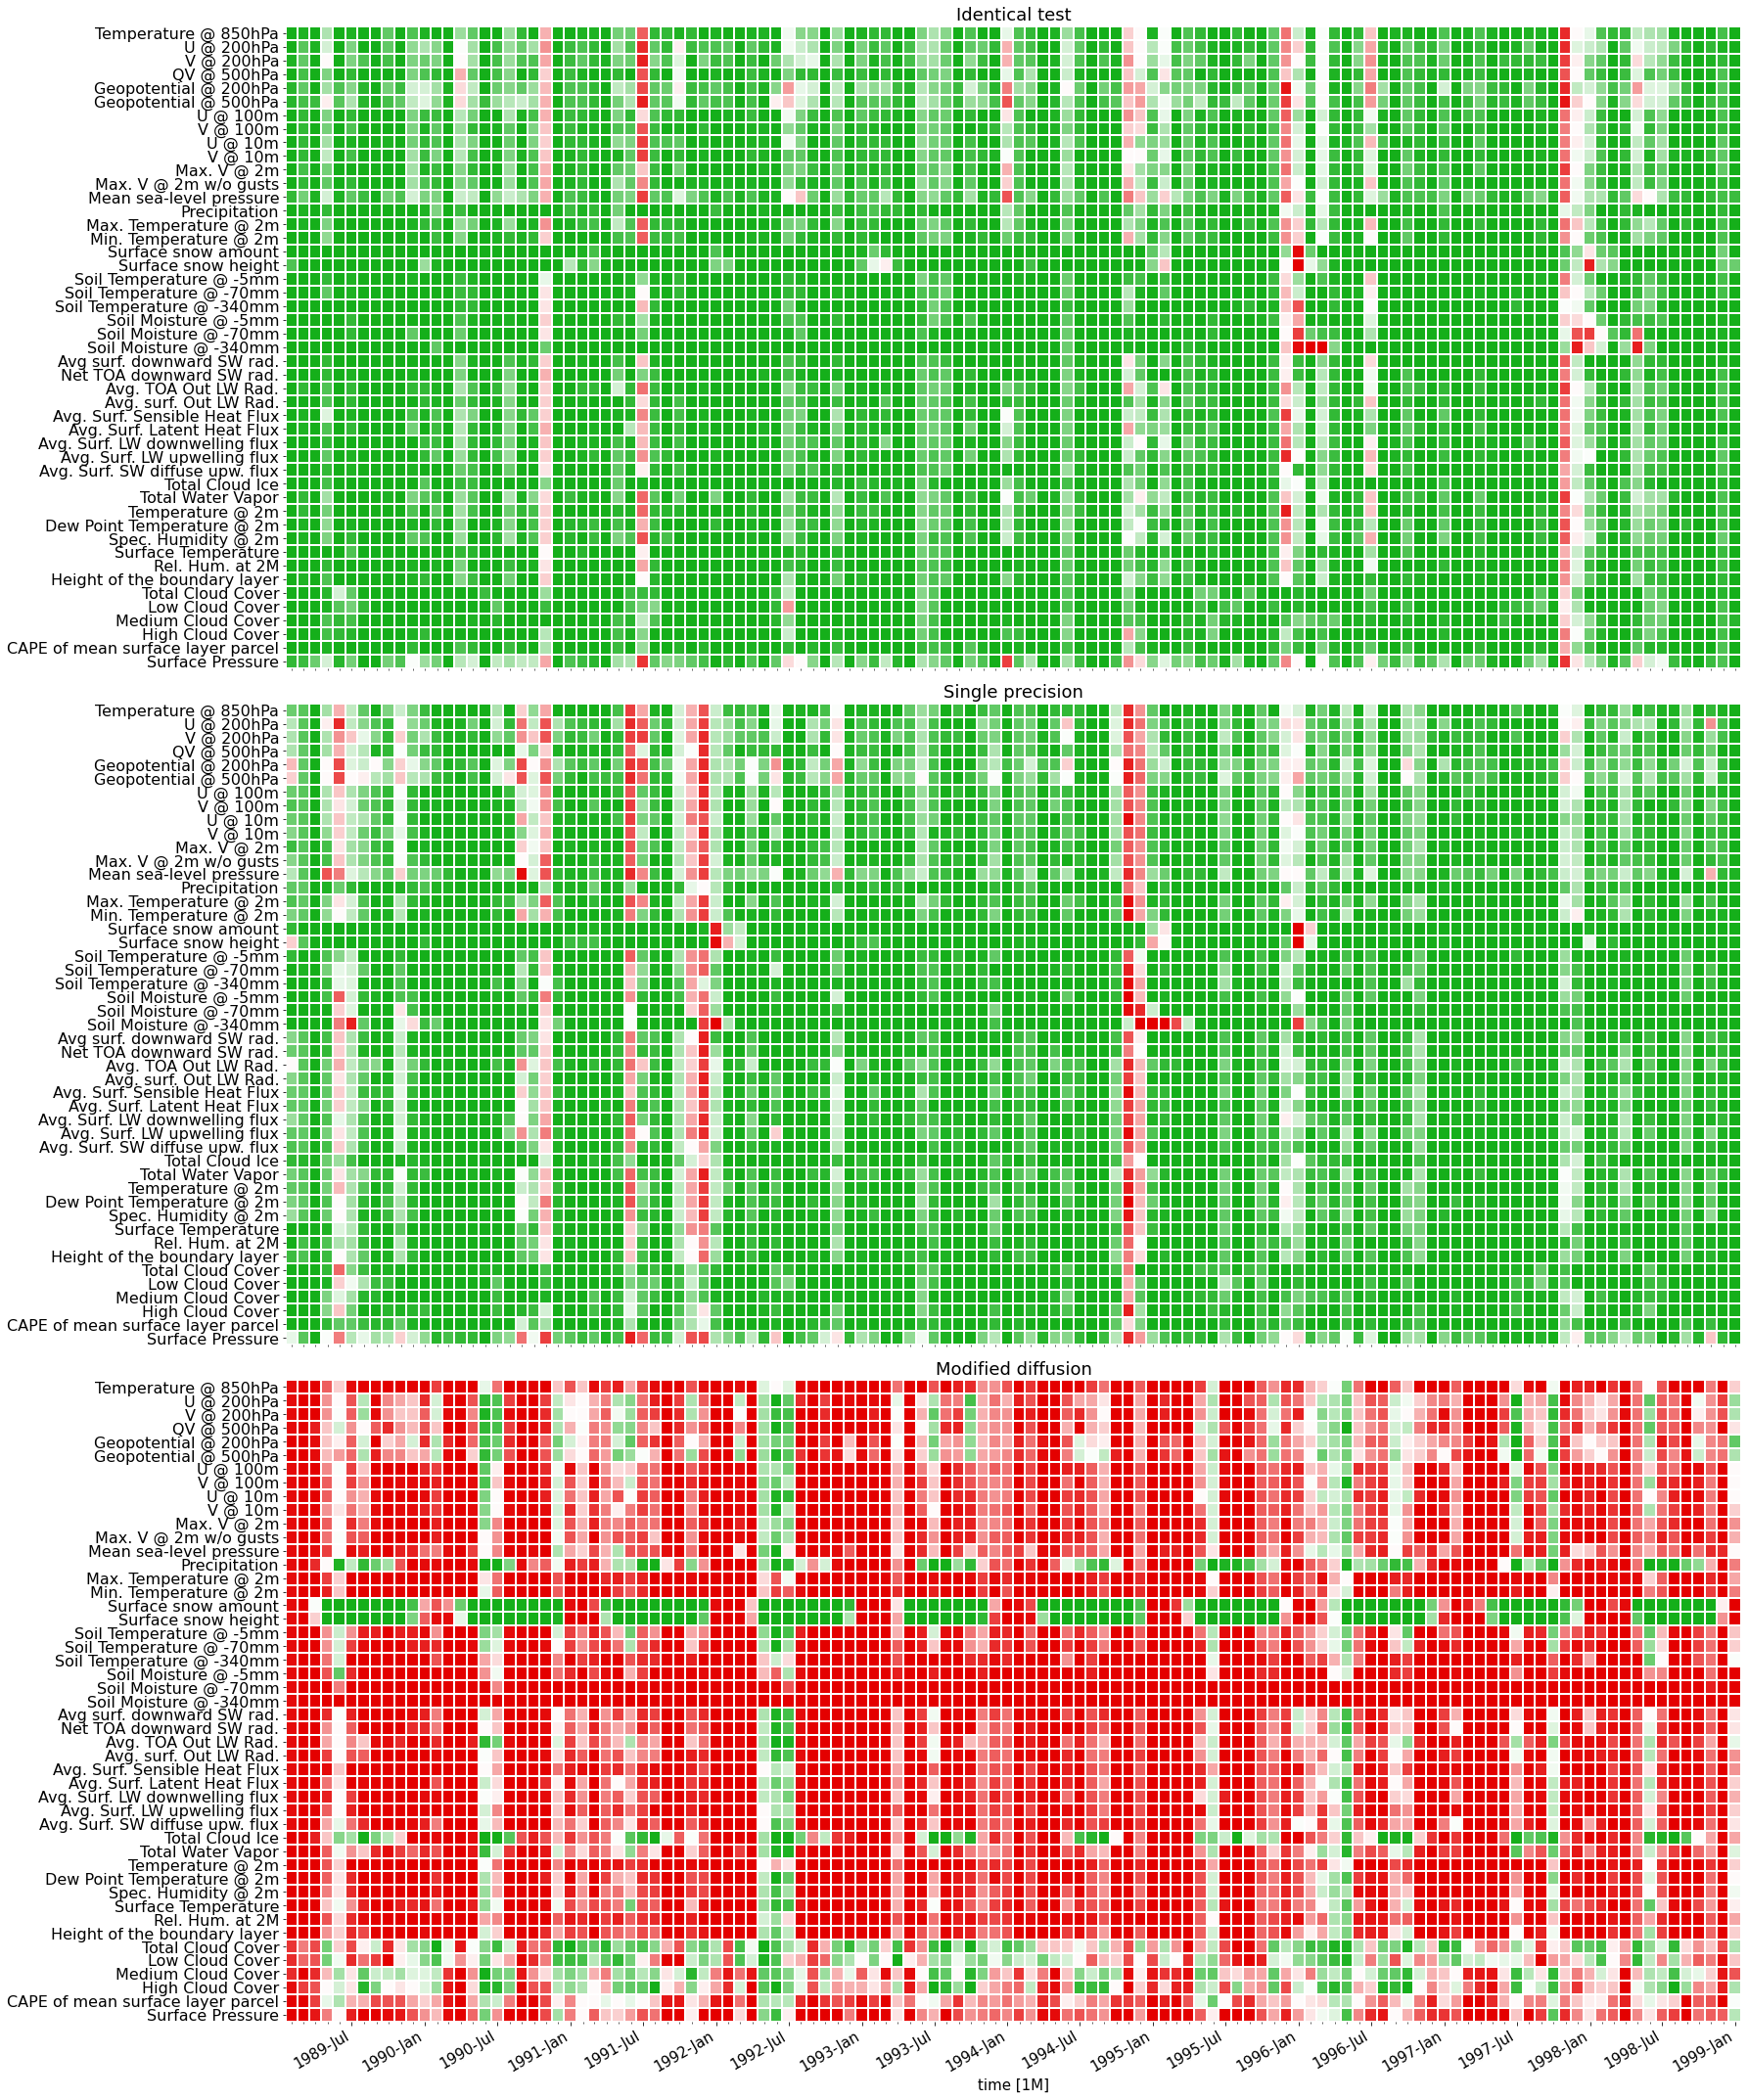

In [7]:
test = "KS"
freq = "1D"
# ana = "sensi"

crit_rej = np.linspace(0.1, 0.4, 31)
thing = np.empty(len(variablemap.keys()))
c_crit = np.empty(len(variablemap.keys()))
to_plot = np.empty(len(variablemap.keys()), dtype=object)

i = 0
for varname in variablemap.keys():
    with open(f"{PATHBASE}/results/{ana}_{freq}/decisions_{varname}.pkl", "rb") as handle:
        decisions = pkl.load(handle)
    avgdec = np.nanmean(decisions, axis=(-1, -2))
    decmean0 = np.nanmean(avgdec[0, ..., np.newaxis] > crit_rej, axis=0)
    decmean1 = np.nanmean(avgdec[-1, ..., np.newaxis] > crit_rej, axis=0)
    # c_crit[i] = crit_rej[np.argmax(np.abs(decmean0 - decmean1) / decmean1)]
    c_crit[i] = crit_rej[np.argmin(np.abs(decmean0 - 0.05))]
    is12h = variablemap[varname][0][:2] == "12"
    time = pd.date_range("1989-01-01", periods=avgdec.shape[-1], freq="12H" if is12h else freq, inclusive="left")

    to_plot[i] = xr.DataArray(
        data=(avgdec > c_crit[i]),
        dims=["ensembles", "time"],
        coords=dict(
            ensembles=np.arange(avgdec.shape[0]),
            time=time,
        ),
    ).resample(time="1M").mean()
    i += 1
np.savetxt(f"c_crit_{ana}.csv", c_crit, delimiter=",")

vlabels = [variablemap[key][-1] for key in variablemap]
xlabel = f"time [1M]"

meandecs2 = np.empty((len(variablemap), n_ens[ana] - 2))

fig, axes = plt.subplots(n_ens[ana] - 2, 1, figsize=(25, 10 * (n_ens[ana] - 2)), tight_layout=True)

for k in range(n_ens[ana] - 2):
    ax = axes[k]
    for key in ax.spines.keys():
        ax.spines[key].set_visible(False)
    this_thing = xr.concat([to_plot[i][k, :] for i in range(len(variablemap) - 1, -1, -1)], dim="variable")
    xr.plot.pcolormesh(this_thing, cmap=CMAP, ax=ax, vmax=1, vmin=0, 
                       rasterized=True, linewidth=1.8, add_colorbar=False, 
                       edgecolors="white", add_labels=False
                      )
    meandecs2[:, k] = np.mean(this_thing.values, axis=1)[::-1]
    ax.xaxis_date()
    ax.set_yticks(np.arange(len(vlabels)))
    ax.set_yticklabels(vlabels[::-1], rotation=0, fontsize=16)
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    if k<2:
        ax.set_xticks([])
    else:
        ax.set_xlabel(xlabel)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    ax.set_title(titles[ana][k])

plt.savefig("Figures/final_KS_method2_sensi.png")
np.savetxt(f"meandecs2_{ana}.csv", meandecs2, delimiter=",")

## Final decision on averaged rejections

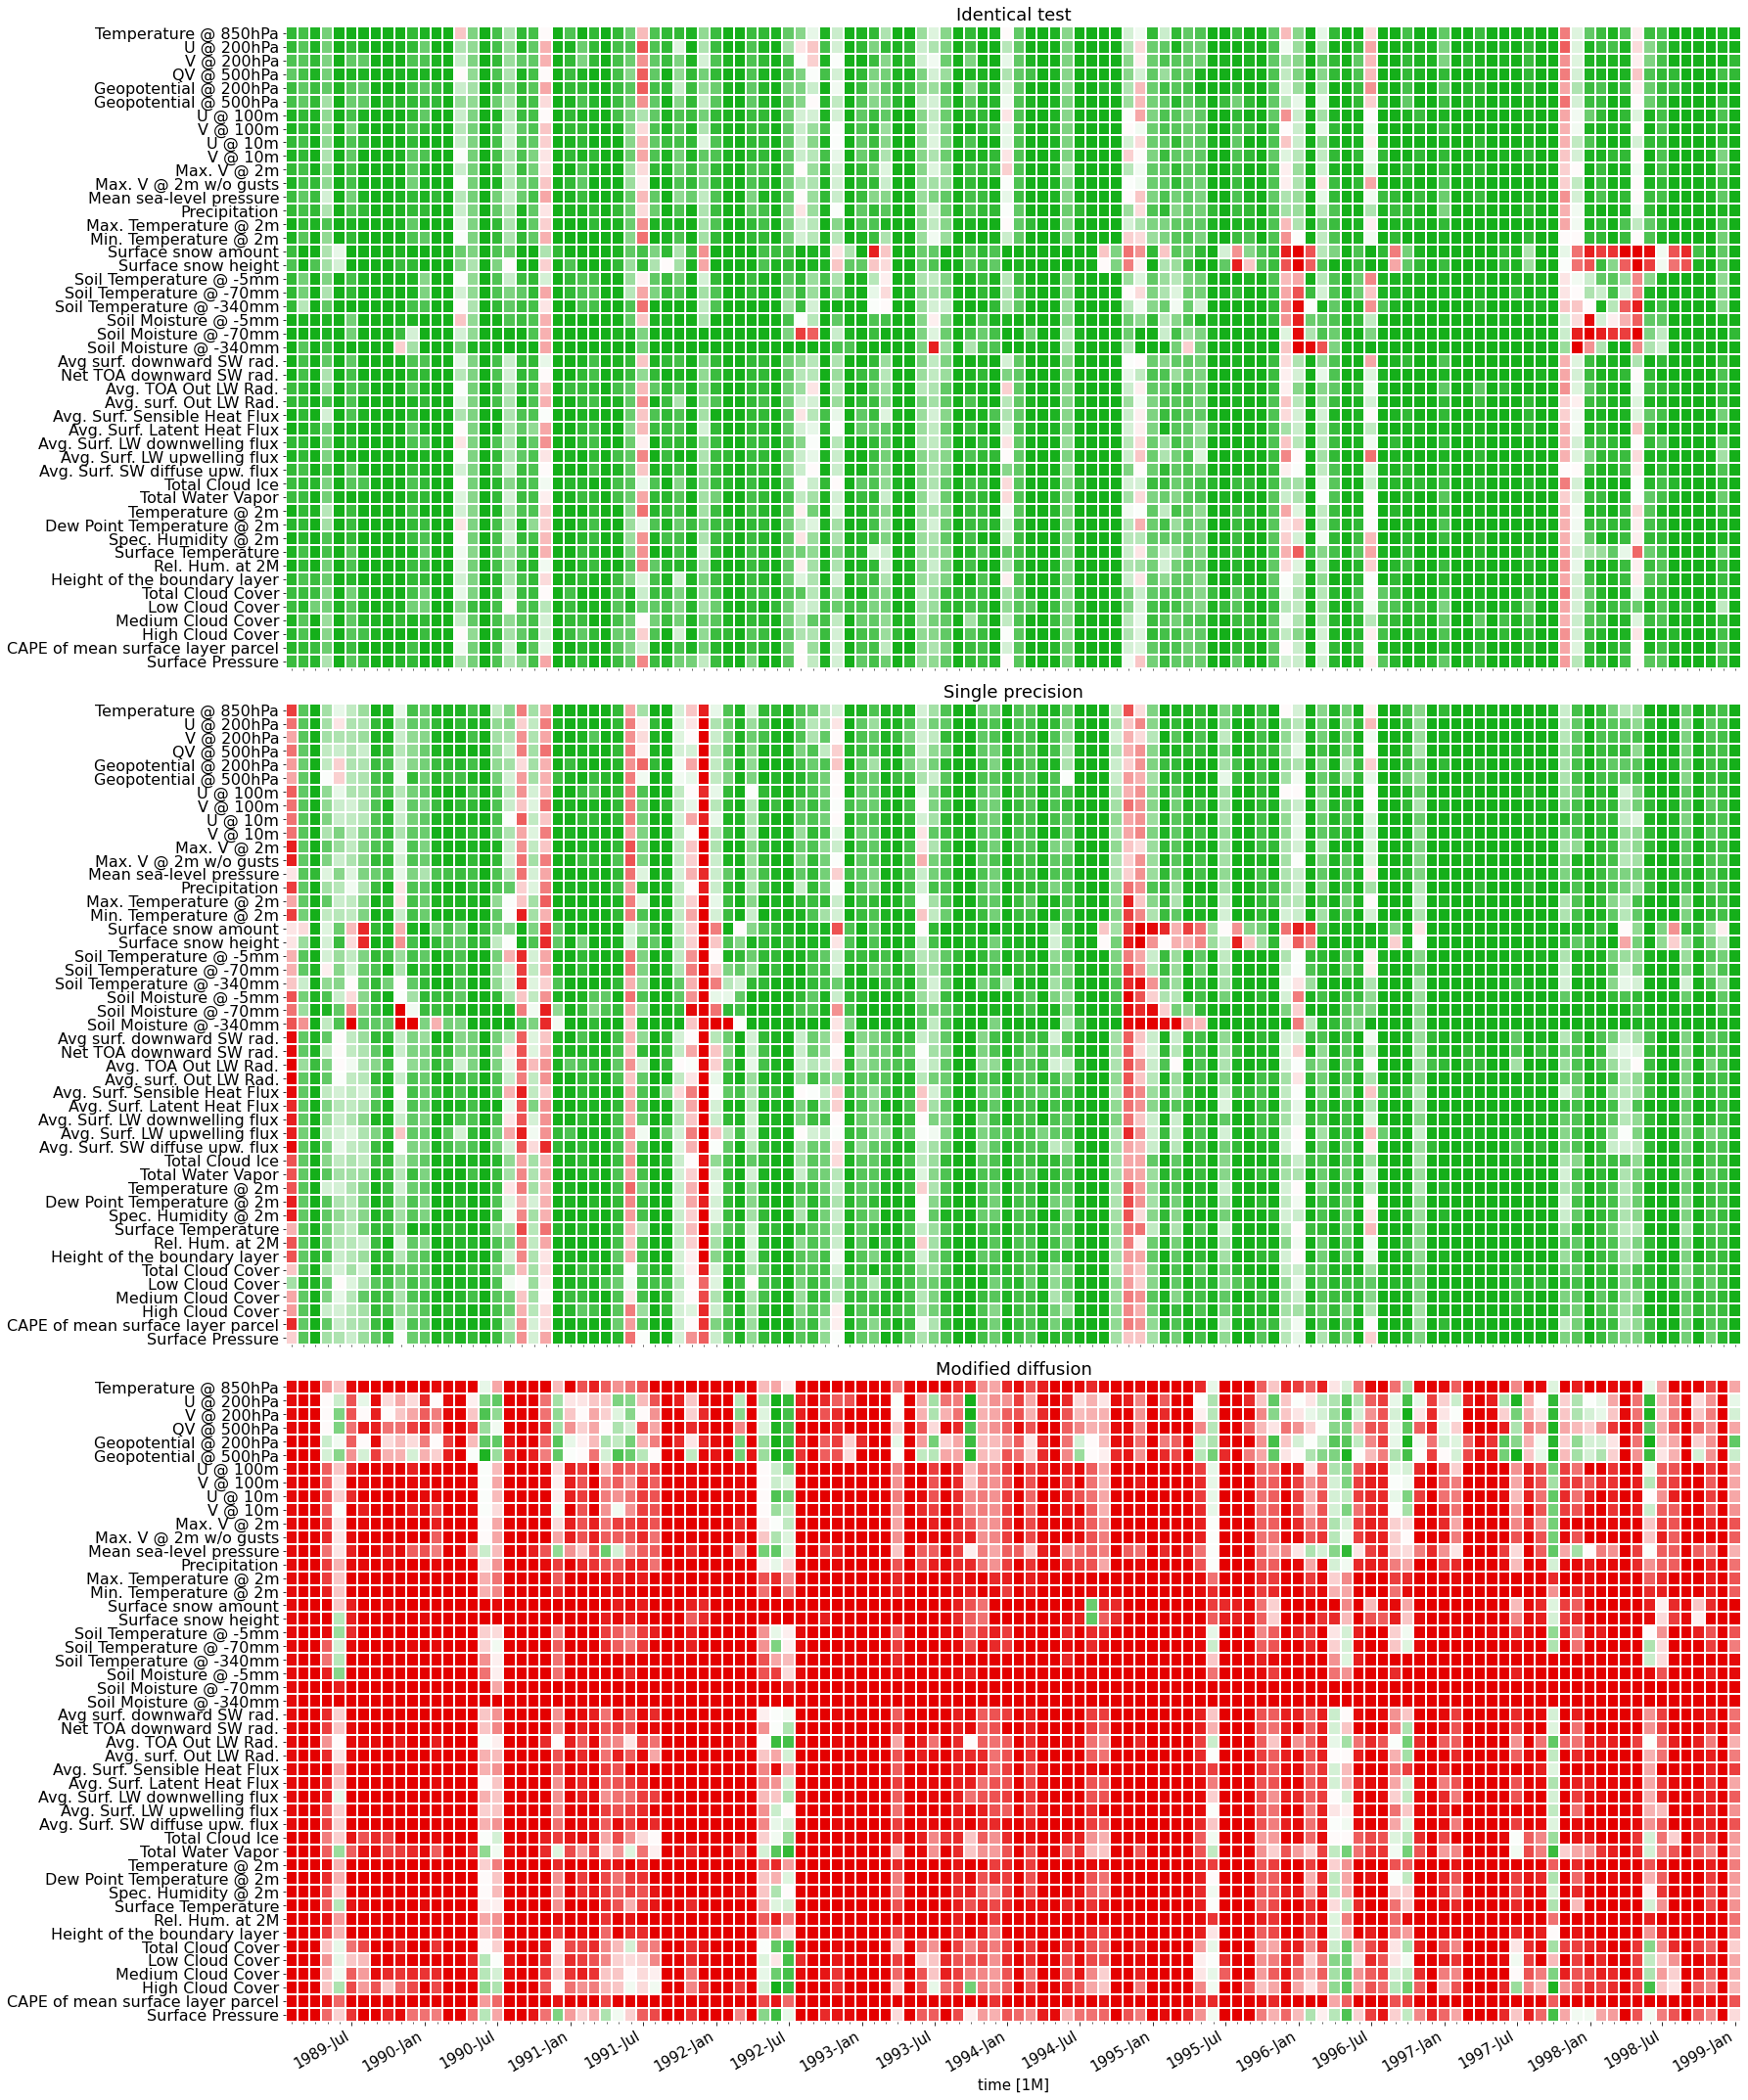

In [8]:
test = "KS"
freq = "1D"
# ana="sensi"

# crit_rej = np.linspace(0.1, 0.4, 31)
thing = np.empty(len(variablemap.keys()))
# c_crit = np.empty(len(variablemap.keys()))
to_plot = np.empty(len(variablemap.keys()), dtype=object)

i = 0
reresampletime = "1M"
for varname in variablemap.keys():
    with open(f"{PATHBASE}/results/{ana}_{freq}/avgdecs_{varname}.pkl", "rb") as handle:
        avgdecs = pkl.load(handle)
    is12h = variablemap[varname][0][:2] == "12"
    time = pd.date_range("1989-01-01", periods=avgdecs.shape[-1], freq="12H" if is12h else freq, inclusive="left")

    to_plot[i] = xr.DataArray(
        data=avgdecs,
        dims=["ensembles", "time"],
        coords=dict(
            ensembles=np.arange(avgdec.shape[0]),
            time=time,
        ),
    ).resample(time=reresampletime).mean()
    i += 1

vlabels = [variablemap[key][-1] for key in variablemap]
xlabel = f"time [1M]"

meandecs1 = np.empty((len(variablemap), avgdec.shape[0]))

fig, axes = plt.subplots(n_ens[ana] - 2, 1, figsize=(25, 10 * (n_ens[ana] - 2)), tight_layout=True)

for k in range(n_ens[ana] - 2):
    ax = axes[k]
    for key in ax.spines.keys():
        ax.spines[key].set_visible(False)
    this_thing = xr.concat([to_plot[i][k, :] for i in range(len(variablemap) - 1, -1, -1)], dim="variable")
    xr.plot.pcolormesh(this_thing, cmap=CMAP, ax=ax, vmax=1, vmin=0, 
                       rasterized=True, linewidth=1.8, add_colorbar=False, 
                       edgecolors="white", add_labels=False
                      )
    # sns.heatmap(
    #     1 - this_thing, linewidth=1.8, cmap=cmap, ax=ax, cbar=False, vmax=1, vmin=0
    # )
    meandecs1[:, k] = np.mean(this_thing.values, axis=1)[::-1]
    ax.xaxis_date()
    ax.set_yticks(np.arange(len(vlabels)))
    ax.set_yticklabels(vlabels[::-1], rotation=0, fontsize=16)
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    if k<2:
        ax.set_xticks([])
    else:
        ax.set_xlabel(xlabel)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    ax.set_title(titles[ana][k])

plt.savefig("Figures/final_KS_method1_sensi.png")
np.savetxt(f"meandecs1_{ana}.csv", meandecs1, delimiter=",")

## FDR

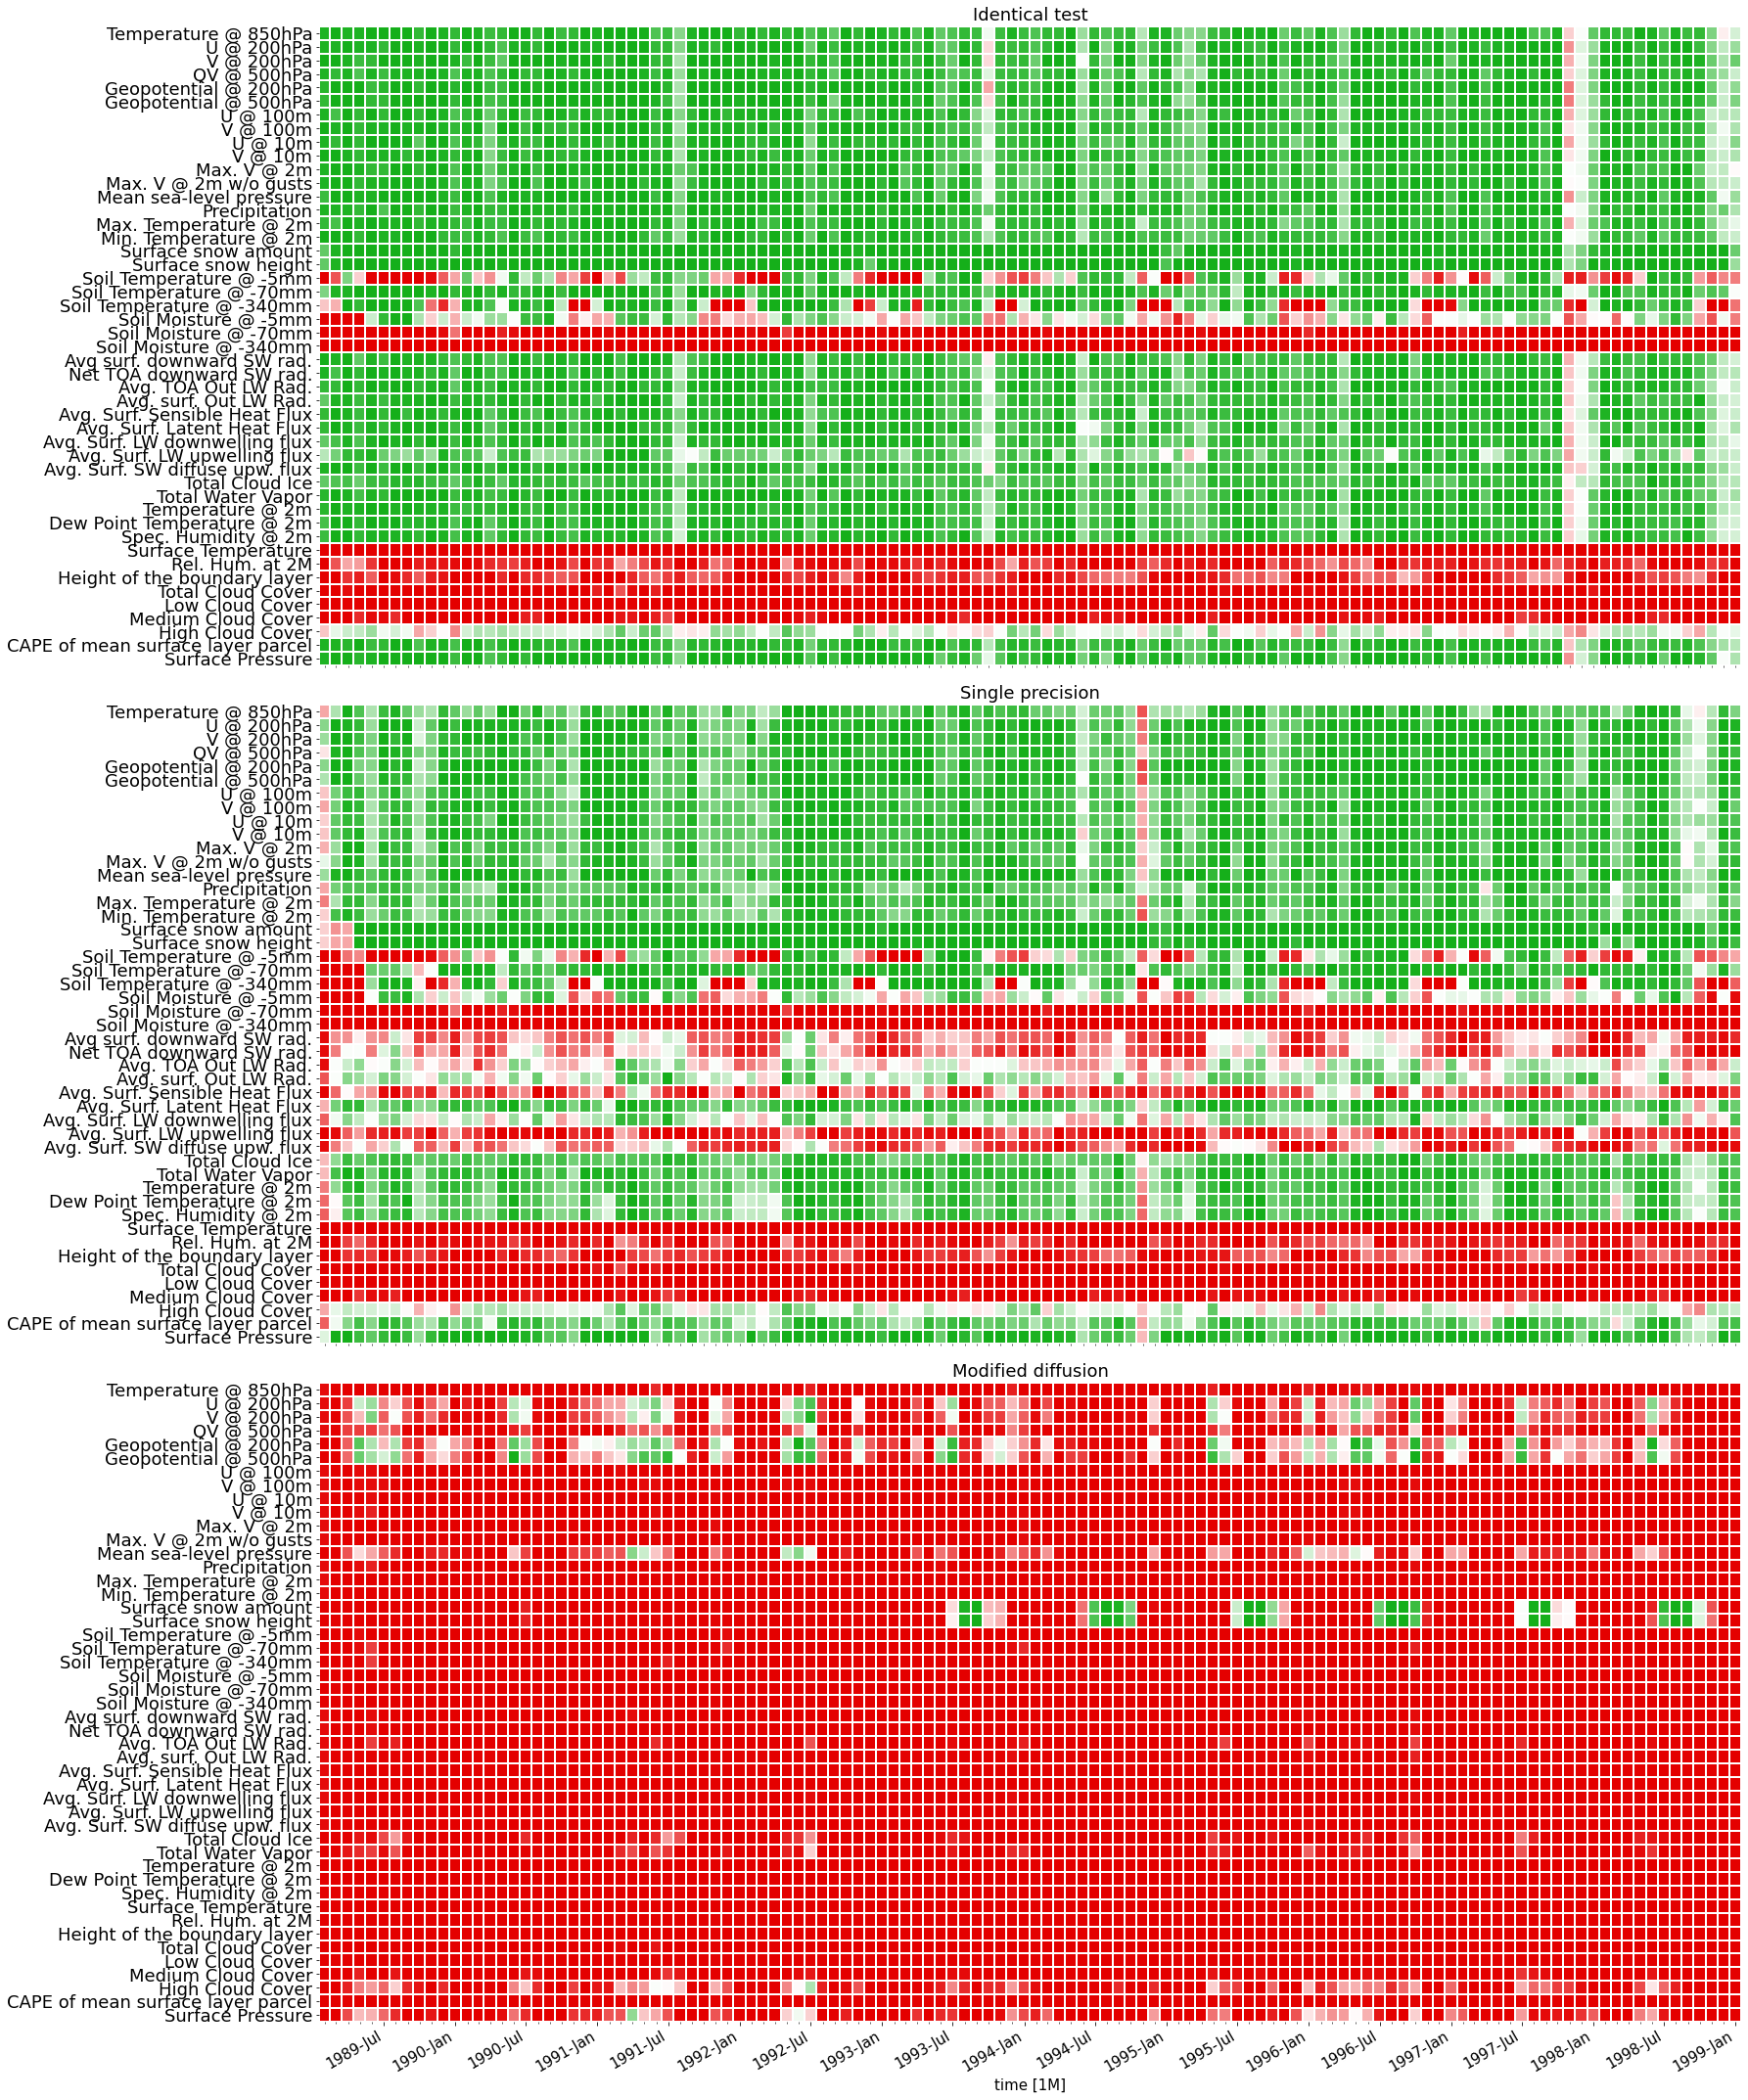

In [11]:
test = "KS"
freq = "1D"
# ana = "sensi"

thing = np.empty(len(variablemap.keys()))
to_plot = np.empty(len(variablemap.keys()), dtype=object)
m = 4 if ana == "sensi" else 3 

reresampletime = "1M"
with open(f"{PATHBASE}/results/fdr_decisions_{ana}.pkl", "rb") as handle:
    decisions = pkl.load(handle)
for varname, k in zip(variablemap.keys(), range(len(variablemap))):
    is12h = variablemap[varname][0][:2] == "12"
    decision = decisions[k].reshape((m, decisions[k].shape[1], -1))
    dec0 = np.mean(decision[0], axis=0)
    dec1 = np.mean(decision[-1], axis=0)
    n = np.nanargmin(np.abs(dec0 - 0.05))
    # print(varname, np.amin(dec0), np.amax(dec0))
    # n = np.argmax(np.ma.masked_invalid(np.abs(dec1-dec0) / dec0))
    # print(n, (np.abs(dec0 - dec1) / dec0)[n])
    decision = decision[:, :, n]
    time = pd.date_range("1989-01-01", periods=decision.shape[1], freq="12H" if is12h and freq == "1D" else freq, inclusive="left")

    to_plot[k] = xr.DataArray(
        data=decision,
        dims=["ensembles", "time"],
        coords=dict(
            ensembles=np.arange(m),
            time=time,
        ),
    ).resample(time=reresampletime).mean()

cmap=CMAP
vlabels = [variablemap[key][-1] for key in variablemap]
xlabel = f"time [1M]"

meandecs3 = np.empty((len(variablemap), to_plot[0].shape[0]))

fig, axes = plt.subplots(n_ens[ana] - 2, 1, figsize=(25, 10 * (n_ens[ana] - 2)), tight_layout=True)

for k in range(n_ens[ana] - 2):
    ax = axes[k]
    for key in ax.spines.keys():
        ax.spines[key].set_visible(False)
    this_thing = xr.concat([to_plot[i][k, :] for i in range(len(variablemap) - 1, -1, -1)], dim="variable")
    xr.plot.pcolormesh((1 - this_thing), cmap=cmap, ax=ax, vmax=1, vmin=0, 
                       rasterized=True, linewidth=1.8, add_colorbar=False, 
                       edgecolors="white", add_labels=False
                      )
    # sns.heatmap(
    #     1 - this_thing, linewidth=1.8, cmap=cmap, ax=ax, cbar=False, vmax=1, vmin=0
    # )
    meandecs3[:, k] = np.mean(this_thing.values, axis=1)[::-1]
    ax.xaxis_date()
    ax.set_yticks(np.arange(len(vlabels)))
    ax.set_yticklabels(vlabels[::-1], rotation=0, fontsize=18)
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    if k<2:
        ax.set_xticks([])
    else:
        ax.set_xlabel(xlabel)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
    ax.set_title(titles[ana][k])

# plt.savefig("Figures/final_KS_fdR_sensi.pdf")
np.savetxt(f"meandecs3_{ana}.csv", meandecs3, delimiter=",")

## Comparisons

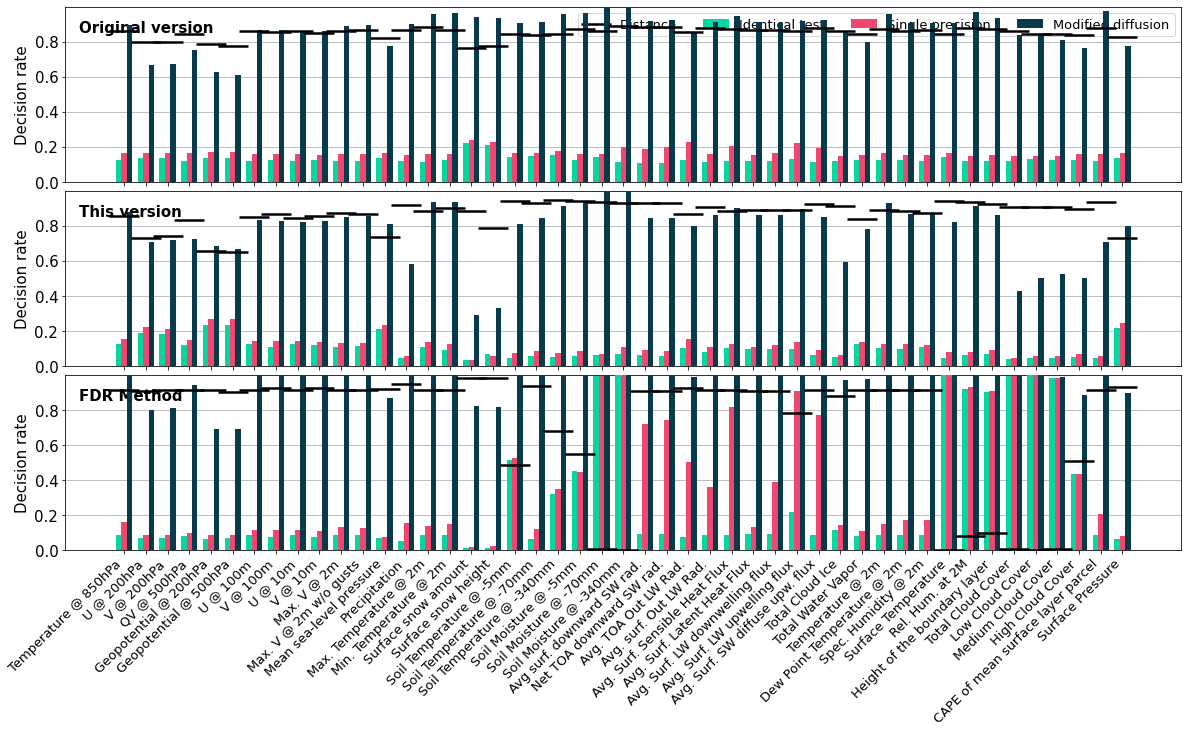

In [10]:
fig, axes = plt.subplots(3, figsize=(20, 10), sharex=True)
fig.subplots_adjust(hspace=0.05)
colors = ["#"]
to_plot = [np.loadtxt(f"meandecs{j}_{ana}.csv", delimiter=",") for j in range(1, 4)]
comp_titles = ["Original version", "This version", "FDR Method"]
# ana = "main"
width= 1 / (n_ens[ana] - 1)
barcenters = np.linspace(-0.5, 0.5, n_ens[ana])[1:-1]
thesecolors = {
    "main": [COLORS[2], COLORS[0], COLORS[4]],
    "sensi": LinearSegmentedColormap.from_list(
        'bdb', [
            COLORS[2],
            COLORS[4]
        ], N=4)(np.linspace(0, 1, 4))
}
x = np.arange(to_plot[0].shape[0])

for i in range(3):
    ax = axes[i]
    toplt = to_plot[i]
    ax.grid(True, axis='y', zorder=-10)
    for j in range(n_ens[ana] - 2):
        ax.bar(x + barcenters[j], toplt[:, j], width, color=thesecolors[ana][j], label=titles[ana][j], zorder=10)
    distance = np.nan_to_num(np.abs((toplt[:, -1] - toplt[:, 0])) / toplt[:, -1], nan=0, posinf=1)
    ax.plot(x, distance, 'k_', mew=2.5, ms=30, label="Distance", zorder=20)
    at = AnchoredText(
        comp_titles[i], prop=dict(size=15, fontweight="bold"), loc='upper left', frameon=False)
    ax.add_artist(at)
    ax.set_ylim([0, 1])
    ax.set_yticks(np.linspace(0, 0.8, 5))
    ax.set_ylabel("Decision rate")
axes[0].legend(fontsize=13, ncol=n_ens[ana] - 1, loc="upper right")
ax.set_xticks(np.arange(len(vlabels)))
ax.set_xticklabels(vlabels, rotation=45, ha="right", fontsize=13)
plt.savefig(f"Figures/Comparison_methods_FDR_{ana}.pdf", bbox_inches='tight', dpi=300)

# Investigate differences between methodologies

In [5]:
ana = "main"
freq = "1D"
test = "KS"
varname = "clct"
bigname = variablemap[varname][1]
k = 12
darr = loaddarr(varname, bigname, ensembles[ana], k, ana=ana, big=True, values=False, bs=None)
results = open_results(varname, ana, freq, test, k)
decisions = open_decisions(varname, ana, freq, test)
avgdecs = open_avgdecs(varname, ana, freq, test)

In [50]:
bs = metadata["boundary_size"]

results_padded = results.pad({"rlat": bs, "rlon": bs}, "constant", None, 0)
results_padded = results_padded.assign_coords({"rlat": darr.rlat,  "rlon": darr.rlon}).assign_coords({"lat": darr.lat, "lon": darr.lon})

decisions_padded = decisions.pad({"rlat": bs, "rlon": bs}, "constant", None, 0)
decisions_padded = decisions_padded.assign_coords({"rlat": darr.rlat,  "rlon": darr.rlon}).assign_coords({"lat": darr.lat, "lon": darr.lon})

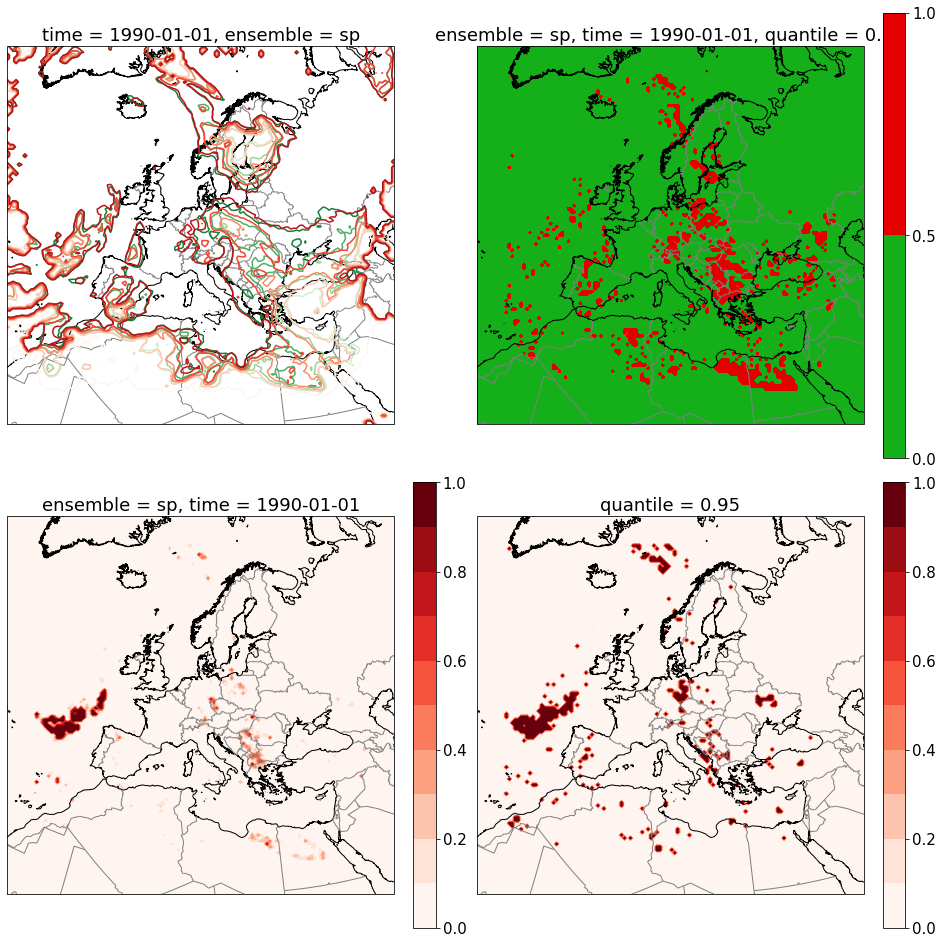

In [70]:
from matplotlib import ticker, cm
fig, axes = create_axes(2, 2)
axes = axes.flatten()
darr.sel(ensemble="ref").isel(time=0).mean(dim="member").plot.contour(ax=axes[0], cmap="Greens")
darr.sel(ensemble="sp").isel(time=0).mean(dim="member").plot.contour(ax=axes[0], cmap="Reds")
results_padded.sel(ensemble="sp").isel(time=0).mean(dim="sel").plot.contourf(ax=axes[2], cmap="Reds", levels=11)
results_padded.sel(ensemble="control").isel(time=0).quantile(q=metadata["decision_quantile"], dim="sel").plot.contourf(ax=axes[3], cmap="Reds", levels=11)
# decisions_padded.sel(ensemble="sp").isel(time=0).plot.contourf(ax=axes[1], cmap=CMAP, levels=3)
onethespot = results_padded.sel(ensemble="sp").isel(time=0).mean(dim="sel") > results_padded.sel(ensemble="control").isel(time=0).quantile(q=metadata["decision_quantile"], dim="sel")
onethespot.plot.contourf(ax=axes[1], cmap=CMAP, levels=3)
plt.show()

In [41]:
results_padded.sel(ensemble="sp").isel(time=0).mean(dim="sel")

<xarray.DataArray (rlat: 129, rlon: 132)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    ensemble  <U2 'sp'
    time      datetime64[ns] 1990-01-01
  * rlat      (rlat) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
  * rlon      (rlon) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan